In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ===========================
# 📌 Preprocessing
# ===========================
def preprocess_dataset(df, label_cols, drop_cols=None):
    df = df.copy()
    y = df[label_cols].values.argmax(axis=1)
    if drop_cols is None:
        drop_cols = []
    X = df.drop(columns=label_cols + drop_cols)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y, scaler

# ===========================
# ⚖️ Class Weights
# ===========================
def compute_class_weights(y, num_classes, method='balanced'):
    if method == 'balanced':
        weights = compute_class_weight('balanced', classes=np.arange(num_classes), y=y)
    elif method == 'inverse':
        class_counts = np.bincount(y)
        weights = 1. / (class_counts + 1e-5)
    else:
        weights = np.ones(num_classes)
    return torch.tensor(weights, dtype=torch.float32)

# ===========================
# 🔄 Dataloaders
# ===========================
def create_dataloaders(X, y, test_size=0.2, val_size=0.1, batch_size=64, random_state=42):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    val_relative_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_relative_size, stratify=y_train_val)

    def to_tensor_dataset(X, y):
        return TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))

    return (DataLoader(to_tensor_dataset(X_train, y_train), batch_size=batch_size, shuffle=True),
            DataLoader(to_tensor_dataset(X_val, y_val), batch_size=batch_size),
            DataLoader(to_tensor_dataset(X_test, y_test), batch_size=batch_size))

# ===========================
# 🧠 MLP Model
# ===========================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[256, 128, 64], num_classes=6,
                 dropout_rates=[0.4, 0.3, 0.2], activation='relu', use_batchnorm=True):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h_dim, dropout in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev_dim, h_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h_dim))
            layers.append({'relu': nn.ReLU(), 'leakyrelu': nn.LeakyReLU(0.1), 'gelu': nn.GELU()}[activation])
            layers.append(nn.Dropout(dropout))
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ===========================
# 🔥 Focal Loss (optional)
# ===========================
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, input, target):
        log_prob = F.log_softmax(input, dim=1)
        prob = torch.exp(log_prob)
        focal_weight = (1 - prob).pow(self.gamma)
        return F.nll_loss(focal_weight * log_prob, target, weight=self.weight, reduction=self.reduction)

# ===========================
# 🌡️ Temperature Scaling
# ===========================
def apply_temperature_scaling(logits, temperature=1.0):
    return logits / temperature

# ===========================
# 🎯 Threshold Tuning
# ===========================
def find_best_thresholds(probabilities, labels, num_classes):
    thresholds = np.linspace(0.1, 0.9, 9)
    best_thresholds = np.zeros(num_classes)
    for class_idx in range(num_classes):
        best_f1, best_thresh = 0, 0.5
        for thresh in thresholds:
            preds = (np.array(probabilities)[:, class_idx] > thresh).astype(int)
            true = (np.array(labels) == class_idx).astype(int)
            f1 = f1_score(true, preds)
            if f1 > best_f1:
                best_f1, best_thresh = f1, thresh
        best_thresholds[class_idx] = best_thresh
    return best_thresholds

# ===========================
# 📊 Metric Plots
# ===========================
def plot_per_class_metrics(all_labels, all_preds, label_names):
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, labels=range(len(label_names)))
    x = range(len(label_names))
    plt.figure(figsize=(12, 5))
    width = 0.25
    plt.bar([p - width for p in x], precision, width=width, label='Precision')
    plt.bar(x, recall, width=width, label='Recall')
    plt.bar([p + width for p in x], f1, width=width, label='F1-score')
    plt.xticks(ticks=x, labels=label_names, rotation=45, ha='right')
    plt.title("Per-Class Precision, Recall, and F1-score")
    plt.ylabel("Score")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ===========================
# 🧾 Global F1 Scores
# ===========================
def print_f1_summary(all_labels, all_preds):
    macro = f1_score(all_labels, all_preds, average='macro')
    weighted = f1_score(all_labels, all_preds, average='weighted')
    print(f"\n🔍 Macro F1 Score: {macro:.4f}")
    print(f"🔍 Weighted F1 Score: {weighted:.4f}")
    return macro, weighted


c:\Users\lamia\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (



[One-hot distribution (argmax, raw)]
OK               88196
calving            793
lameness           428
mastitis           536
oestrus           3505
other_disease      898
Name: count, dtype: int64
[One-hot sanity] all_zero=0, multi_hot=0, any_nan=0


Training:  96%|█████████▋| 193/200 [57:33<02:05, 17.90s/it] 


Early stopping at epoch 194


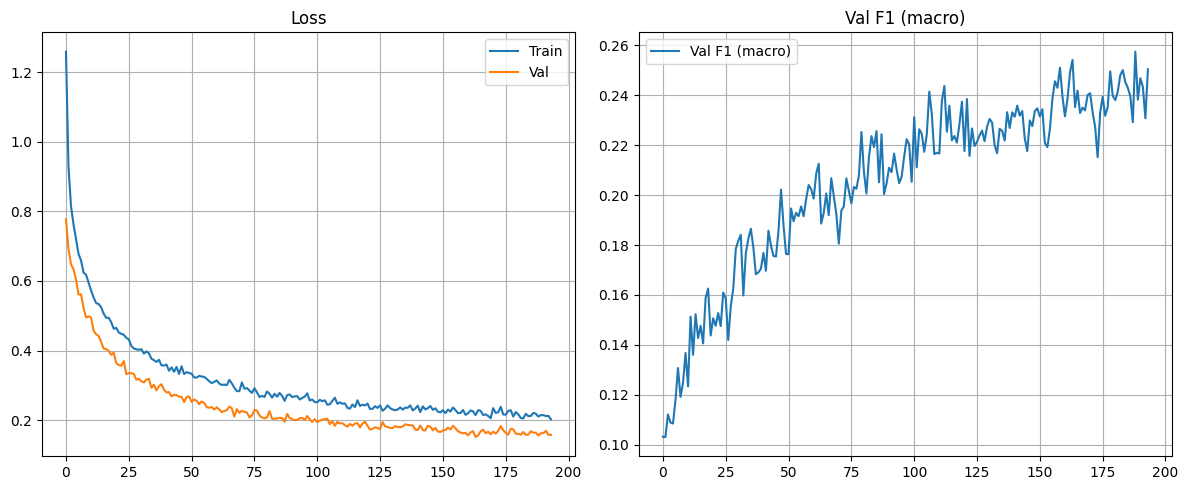

✓ Learned temperature on validation: T = 0.648

[One-hot distribution (argmax, raw)]
OK               9800
calving            88
lameness           47
mastitis           60
oestrus           390
other_disease     100
Name: count, dtype: int64
[One-hot sanity] all_zero=0, multi_hot=0, any_nan=0

📊 Holdout Classification Report
               precision    recall  f1-score   support

      oestrus       0.09      0.78      0.16       390
      calving       0.12      0.94      0.22        88
     lameness       0.08      1.00      0.15        47
     mastitis       0.09      0.95      0.16        60
other_disease       0.13      0.95      0.23       100
           OK       0.99      0.43      0.60      9800

     accuracy                           0.46     10485
    macro avg       0.25      0.84      0.25     10485
 weighted avg       0.93      0.46      0.57     10485



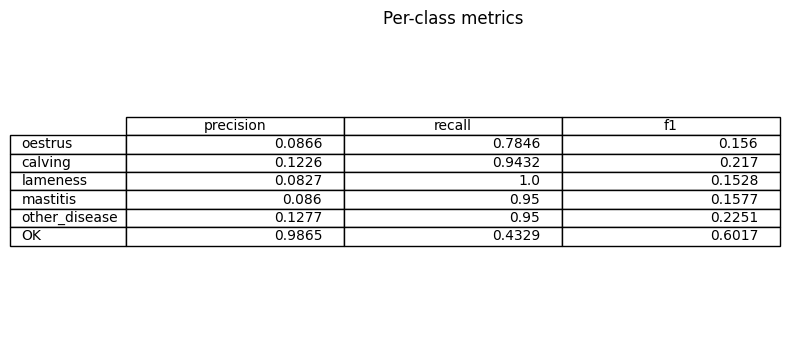

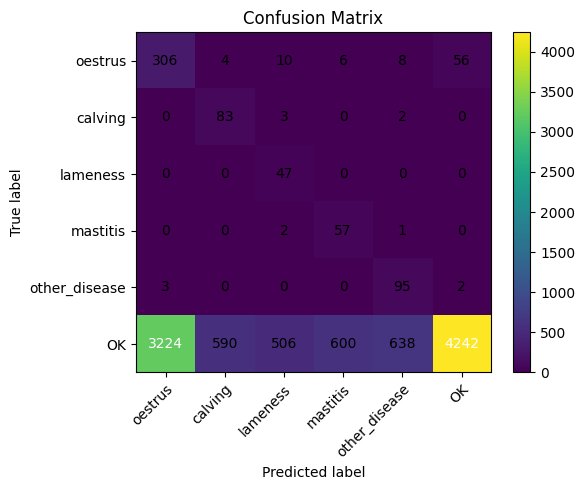


Summary:
  Accuracy      : 0.4607
  F1 (macro)    : 0.2517
  F1 (weighted) : 0.5738
Unique predicted classes on HOLDOUT: [0 1 2 3 4 5]


In [4]:
# -*- coding: utf-8 -*-
# Robust MLP pipeline with label cleaning (NaN + all-zero handling),
# target/one-hot auto-detection, feature alignment, focal loss, temp scaling.

import os, math, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_fscore_support,
                             accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **k): return x

warnings.filterwarnings("ignore")

# ======================= CONFIG =======================
INCLUDE_CALVING = True          # 6 classes with 'calving'; set False for 5 classes (calving rows removed)
PREFER_TARGET_COLUMN = True     # use df['target'] if valid (0..C-1)
ALL_ZERO_POLICY = "drop"        # 'drop' | 'map_to_ok' | 'error'
NAN_POLICY = "drop"             # 'drop' | 'error'

TRAINVAL_PATH = Path(r"C:/Users/lamia/Downloads/final_selected_dataset1_trainval.csv")
HOLDOUT_PATH  = Path(r"C:/Users/lamia/Downloads/final_selected_dataset1_holdout.csv")

SEED = 42
VAL_SIZE = 0.15

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.5, 0.4, 0.3]
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128
LR           = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
LEARN_TEMP   = True

# ======================= UTILS =======================
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def freeze_label_order(include_calving=True):
    if include_calving:
        label_cols = ['oestrus','calving','lameness','mastitis','other_disease','OK']
    else:
        label_cols = ['oestrus','calving','lameness','mastitis','other_disease','OK']
    idx2name = {i: c for i, c in enumerate(label_cols)}
    name2idx = {c: i for i, c in enumerate(label_cols)}
    return label_cols, idx2name, name2idx

def optionally_drop_calving(df, include_calving: bool):
    df = df.copy()
    if include_calving:
        return df
    if 'calving' in df.columns:
        before = len(df)
        df = df[df['calving'] == 0].copy()
        print(f"[INFO] Removed {before-len(df)} rows with calving==1 for 5-class setup.")
    return df

def _validate_target_column(df, n_classes):
    if 'target' not in df.columns:
        return False
    col = df['target']
    if col.isna().any():
        return False
    vals = col.astype(float)
    if not np.all(np.isfinite(vals)): return False
    if not np.all(np.equal(vals, np.floor(vals))): return False
    vals = vals.astype(int)
    if (vals.min() < 0) or (vals.max() >= n_classes): return False
    return True

def _one_hot_sanity(df, label_cols):
    sub = df[label_cols].astype(float)
    row_sums = sub.sum(axis=1)
    bad_all_zero  = int((row_sums == 0).sum())
    bad_multi_hot = int((row_sums > 1.0 + 1e-9).sum())
    bad_nans      = int(sub.isna().any(axis=1).sum())
    dist = sub.idxmax(axis=1).value_counts(dropna=False).sort_index()
    return bad_all_zero, bad_multi_hot, bad_nans, dist

def extract_labels(df, label_cols, all_zero_policy="drop", nan_policy="drop", prefer_target=True):
    """
    Returns:
      y (np.ndarray[int]),
      df_clean (df after cleaning according to policies),
      info (dict)
    """
    df = df.copy()
    n_classes = len(label_cols)

    # Prefer integer target if valid
    if prefer_target and _validate_target_column(df, n_classes):
        y = df['target'].astype(int).values
        return y, df, {"used": "target"}

    # Else use one-hot
    for c in label_cols:
        if c not in df.columns:
            raise ValueError(f"Missing label column '{c}' in dataframe.")

    bad_zero, bad_multi, bad_nan, dist = _one_hot_sanity(df, label_cols)
    print("\n[One-hot distribution (argmax, raw)]")
    print(dist)
    print(f"[One-hot sanity] all_zero={bad_zero}, multi_hot={bad_multi}, any_nan={bad_nan}")

    if bad_multi > 0:
        raise ValueError("Labels must be strictly one-hot (found multi-hot rows). Please fix source data.")

    # Handle NaNs
    if bad_nan > 0:
        if nan_policy == "error":
            raise ValueError(f"Found {bad_nan} NaN in label columns. Set NAN_POLICY='drop' to drop those rows.")
        elif nan_policy == "drop":
            before = len(df)
            mask = ~df[label_cols].isna().any(axis=1)
            df = df.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in label columns.")
        else:
            raise ValueError("NAN_POLICY must be 'drop' or 'error'.")

    # Recompute after NaN drop
    bad_zero, bad_multi, bad_nan, _ = _one_hot_sanity(df, label_cols)
    assert bad_multi == 0 and bad_nan == 0, "Internal: NaN/multi-hot not resolved."

    # Handle all-zero rows
    if bad_zero > 0:
        if all_zero_policy == "error":
            raise ValueError(f"Found {bad_zero} all-zero label rows; use ALL_ZERO_POLICY='drop' or 'map_to_ok'.")
        elif all_zero_policy == "drop":
            before = len(df)
            mask = df[label_cols].sum(axis=1) > 0
            df = df.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with all-zero labels.")
        elif all_zero_policy == "map_to_ok":
            if 'OK' not in label_cols:
                raise ValueError("'map_to_ok' selected but 'OK' not in label_cols.")
            mask_zero = df[label_cols].sum(axis=1) == 0
            df.loc[mask_zero, 'OK'] = 1.0
            print(f"[INFO] Mapped {int(mask_zero.sum())} all-zero rows to OK=1.")
        else:
            raise ValueError("ALL_ZERO_POLICY must be 'drop' | 'map_to_ok' | 'error'.")

    # Final check & y
    bad_zero, bad_multi, bad_nan, _ = _one_hot_sanity(df, label_cols)
    assert bad_zero == 0 and bad_multi == 0 and bad_nan == 0, "Internal: labels still invalid after cleaning."
    y = df[label_cols].astype(float).values.argmax(axis=1)
    return y, df, {"used": "one_hot"}

def ensure_feature_alignment(df, feature_names):
    missing = [c for c in feature_names if c not in df.columns]
    for c in missing:
        df[c] = 0.0
    return df[feature_names].astype(float)

# ======================= MODEL =======================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes,
                 dropout_rates=None, activation='relu', use_batchnorm=True):
        super().__init__()
        if dropout_rates is None: dropout_rates = [0.4] * len(hidden_dims)
        act_map = {
            'relu': nn.ReLU, 'leakyrelu': lambda: nn.LeakyReLU(0.1),
            'gelu': nn.GELU, 'elu': nn.ELU
        }
        Act = act_map.get(activation.lower(), nn.ReLU)

        layers = []
        prev = input_dim
        for h, dr in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm: layers.append(nn.BatchNorm1d(h))
            layers.append(Act())
            if dr and dr > 0: layers.append(nn.Dropout(dr))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, target):
        ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp(1e-6, 1-1e-6)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class _TempScaler(nn.Module):
    def __init__(self, init_T=1.0):
        super().__init__()
        self.logT = nn.Parameter(torch.tensor([math.log(init_T)], dtype=torch.float32))
    def forward(self, logits): return logits / torch.exp(self.logT)
    @property
    def T(self): return float(torch.exp(self.logT).item())

def learn_temperature(model, val_loader, init_T=1.0, max_iter=100, lr=0.01, weight=None):
    model.eval()
    temp = _TempScaler(init_T)
    opt = optim.LBFGS(temp.parameters(), lr=lr, max_iter=max_iter)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    with torch.no_grad():
        logits_list, labels_list = [], []
        for xb, yb in val_loader:
            logits_list.append(model(xb))
            labels_list.append(yb)
        logits = torch.cat(logits_list, 0)
        labels = torch.cat(labels_list, 0)
    def closure():
        opt.zero_grad()
        loss = loss_fn(temp(logits), labels)
        loss.backward()
        return loss
    opt.step(closure)
    return temp.T

# ======================= DATA & TRAIN =======================
def split_fit_scaler(df, label_cols, drop_cols=None, val_size=0.15, random_state=42):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )

    feature_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feature_names = feature_df.columns.tolist()

    X_train, X_val, y_train, y_val = train_test_split(
        feature_df.values, y, test_size=val_size, random_state=random_state, stratify=y
    )
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val   = scaler.transform(X_val)
    return X_train, y_train, X_val, y_val, scaler, feature_names

def make_loaders_from_arrays(X_train, y_train, X_val, y_val, batch_size=128):
    def td(x, y): return TensorDataset(torch.tensor(x, dtype=torch.float32),
                                       torch.tensor(y, dtype=torch.long))
    train_loader = DataLoader(td(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(td(X_val,   y_val),   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def class_weights_from_train(y_train, n_classes):
    w = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
    return torch.tensor(w, dtype=torch.float32)

def train_on_trainval(
    df_trainval, label_cols, drop_cols=None,
    hidden_dims=HIDDEN_DIMS, dropout_rates=DROPOUTS,
    activation=ACTIVATION, use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE, lr=LR, weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS, patience=PATIENCE, min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL, learn_temp=LEARN_TEMP
):
    set_seed(SEED)
    X_tr, y_tr, X_val, y_val, scaler, feature_names = split_fit_scaler(
        df_trainval, label_cols, drop_cols, val_size=VAL_SIZE, random_state=SEED
    )
    n_classes = len(label_cols)
    train_loader, val_loader = make_loaders_from_arrays(X_tr, y_tr, X_val, y_val, batch_size=batch_size)
    class_w = class_weights_from_train(y_tr, n_classes)

    model = CowHealthMLP(
        input_dim=len(feature_names), hidden_dims=hidden_dims, num_classes=n_classes,
        dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm
    )

    criterion = FocalLoss(weight=class_w) if use_focal_loss else nn.CrossEntropyLoss(weight=class_w)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5)

    best_val, best_state = float('inf'), None
    train_loss_hist, val_loss_hist, val_f1_hist = [], [], []
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * xb.size(0)
        run_loss /= len(train_loader.dataset)
        train_loss_hist.append(run_loss)

        model.eval()
        vloss, vpreds, vlabels = 0.0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                vloss += loss.item() * xb.size(0)
                vpreds.extend(out.argmax(1).cpu().numpy())
                vlabels.extend(yb.cpu().numpy())
        vloss /= len(val_loader.dataset)
        val_loss_hist.append(vloss)
        val_f1 = f1_score(vlabels, vpreds, average='macro')
        val_f1_hist.append(val_f1)
        scheduler.step(vloss)

        uniq = np.unique(vpreds)
        if uniq.size == 1:
            print(f"[epoch {epoch+1}] WARNING: only predicted class {uniq[0]} on VAL — check imbalance.")

        if vloss < best_val - min_delta:
            best_val, best_state = vloss, model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_loss_hist,label='Train'); plt.plot(val_loss_hist,label='Val')
    plt.title('Loss'); plt.grid(); plt.legend()
    plt.subplot(1,2,2); plt.plot(val_f1_hist,label='Val F1 (macro)')
    plt.title('Val F1 (macro)'); plt.grid(); plt.legend()
    plt.tight_layout(); plt.show()

    T = 1.0
    if learn_temp:
        T = learn_temperature(model, val_loader, init_T=1.0, lr=0.01, max_iter=100, weight=class_w)
        print(f"✓ Learned temperature on validation: T = {T:.3f}")

    return model, scaler, T, feature_names

# ======================= EVAL =======================
def transform_with_scaler(df, label_cols, drop_cols, scaler, feature_names):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )
    feat_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feat_df = ensure_feature_alignment(feat_df, feature_names)
    X = scaler.transform(feat_df.values)
    return X, y

def plot_per_class_metrics(y_true, y_pred, class_names):
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
    table = pd.DataFrame({'precision': pr, 'recall': rc, 'f1': f1}, index=class_names)
    ax.axis('off'); ax.table(cellText=np.round(table.values, 4), colLabels=table.columns,
                             rowLabels=table.index, loc='center')
    ax.set_title("Per-class metrics"); plt.tight_layout(); plt.show()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

def print_f1_summary(y_true, y_pred):
    print("\nSummary:")
    print(f"  Accuracy      : {accuracy_score(y_true, y_pred):.4f}")
    print(f"  F1 (macro)    : {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"  F1 (weighted) : {f1_score(y_true, y_pred, average='weighted'):.4f}")

def evaluate_on_holdout(model, scaler, df_holdout, label_cols, drop_cols=None,
                        feature_names=None, temperature=1.0, batch_size=128):
    model.eval()
    X_test, y_test = transform_with_scaler(df_holdout, label_cols, drop_cols, scaler, feature_names)
    ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb) / temperature
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\n📊 Holdout Classification Report")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)
    print("Unique predicted classes on HOLDOUT:", np.unique(all_preds))

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

# ======================= MAIN =======================
if __name__ == "__main__":
    set_seed(SEED)

    FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(include_calving=INCLUDE_CALVING)

    df_trainval = pd.read_csv(TRAINVAL_PATH)
    df_holdout  = pd.read_csv(HOLDOUT_PATH)

    df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
    df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

    drop_cols = ['cow','start_time','end_time']
    if 'calving' in df_trainval.columns and 'calving' not in drop_cols:
        drop_cols.append('calving')

    model, scaler, T, feature_names = train_on_trainval(
        df_trainval,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        hidden_dims=HIDDEN_DIMS,
        dropout_rates=DROPOUTS,
        activation=ACTIVATION,
        use_batchnorm=USE_BN,
        batch_size=BATCH_SIZE,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        epochs=EPOCHS,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
        use_focal_loss=USE_FOCAL,
        learn_temp=LEARN_TEMP
    )

    _ = evaluate_on_holdout(
        model, scaler, df_holdout,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        feature_names=feature_names,
        temperature=T,
        batch_size=BATCH_SIZE
    )


Training: 100%|██████████| 200/200 [23:53<00:00,  7.17s/it]


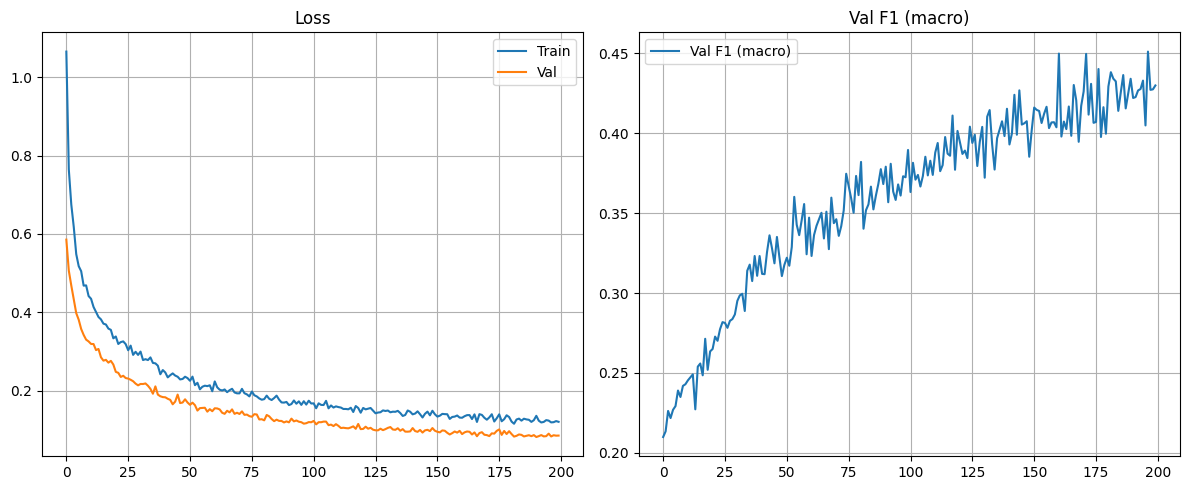

✓ Learned temperature on validation: T = 0.580

📊 Holdout Classification Report
               precision    recall  f1-score   support

      oestrus       0.16      1.00      0.28        57
     lameness       0.21      0.94      0.34       175
     mastitis       0.23      1.00      0.38        32
other_disease       0.19      0.97      0.31        86
           OK       1.00      0.62      0.76      3626

     accuracy                           0.65      3976
    macro avg       0.36      0.90      0.41      3976
 weighted avg       0.93      0.65      0.72      3976



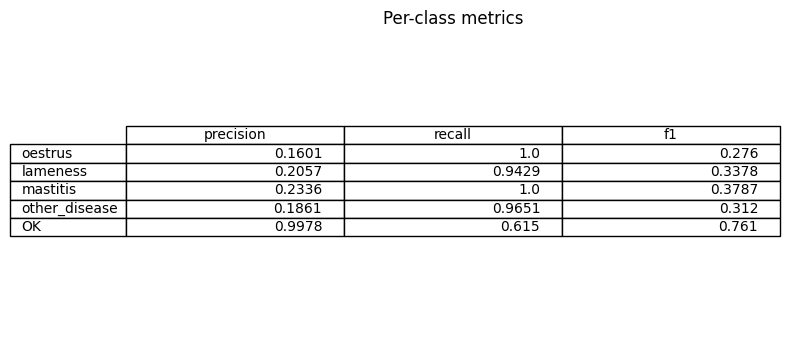

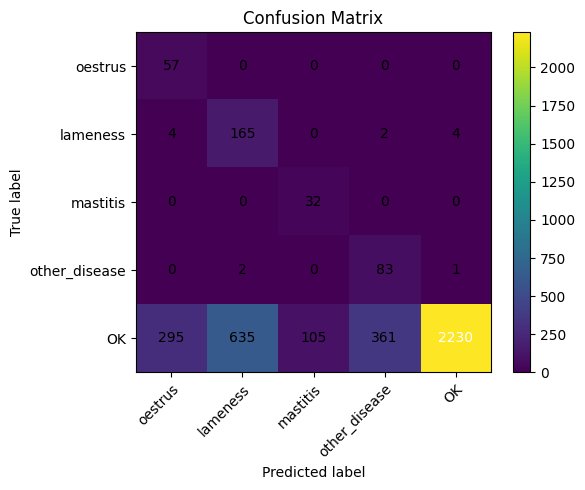


Summary:
  Accuracy      : 0.6456
  F1 (macro)    : 0.4131
  F1 (weighted) : 0.7226
Unique predicted classes on HOLDOUT: [0 1 2 3 4]


In [7]:
# -*- coding: utf-8 -*-
# Robust MLP pipeline with label cleaning (NaN + all-zero handling),
# target/one-hot auto-detection, feature alignment, focal loss, temp scaling.

import os, math, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_fscore_support,
                             accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **k): return x

warnings.filterwarnings("ignore")

# ======================= CONFIG =======================
INCLUDE_CALVING = True          # 6 classes with 'calving'; set False for 5 classes (calving rows removed)
PREFER_TARGET_COLUMN = True     # use df['target'] if valid (0..C-1)
ALL_ZERO_POLICY = "drop"        # 'drop' | 'map_to_ok' | 'error'
NAN_POLICY = "drop"             # 'drop' | 'error'

TRAINVAL_PATH = Path(r"C:/Users/lamia/Downloads/non_augmented_dataset2_trainval.csv")
HOLDOUT_PATH  = Path(r"C:/Users/lamia/Downloads/non_augmented_dataset2_holdout.csv")

SEED = 42
VAL_SIZE = 0.15

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.5, 0.4, 0.3]
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128
LR           = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
LEARN_TEMP   = True

# ======================= UTILS =======================
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def freeze_label_order(include_calving=True):
    if include_calving:
        label_cols = ['oestrus','lameness','mastitis','other_disease','OK']
    else:
        label_cols = ['oestrus','lameness','mastitis','other_disease','OK']
    idx2name = {i: c for i, c in enumerate(label_cols)}
    name2idx = {c: i for i, c in enumerate(label_cols)}
    return label_cols, idx2name, name2idx

def optionally_drop_calving(df, include_calving: bool):
    df = df.copy()
    if include_calving:
        return df
    if 'calving' in df.columns:
        before = len(df)
        df = df[df['calving'] == 0].copy()
        print(f"[INFO] Removed {before-len(df)} rows with calving==1 for 5-class setup.")
    return df

def _validate_target_column(df, n_classes):
    if 'target' not in df.columns:
        return False
    col = df['target']
    if col.isna().any():
        return False
    vals = col.astype(float)
    if not np.all(np.isfinite(vals)): return False
    if not np.all(np.equal(vals, np.floor(vals))): return False
    vals = vals.astype(int)
    if (vals.min() < 0) or (vals.max() >= n_classes): return False
    return True

def _one_hot_sanity(df, label_cols):
    sub = df[label_cols].astype(float)
    row_sums = sub.sum(axis=1)
    bad_all_zero  = int((row_sums == 0).sum())
    bad_multi_hot = int((row_sums > 1.0 + 1e-9).sum())
    bad_nans      = int(sub.isna().any(axis=1).sum())
    dist = sub.idxmax(axis=1).value_counts(dropna=False).sort_index()
    return bad_all_zero, bad_multi_hot, bad_nans, dist

def coerce_one_hot_numeric(df, label_cols):
    """
    Try to coerce a possibly stringy 'one-hot' block into numeric 0/1.
    Rules per cell:
      - numeric -> kept (0/1 expected, but any number allowed until sanity check)
      - string equal to its column name (case-insensitive, trimmed) -> 1
      - '1','true','yes' -> 1
      - '0','false','no','' (empty) -> 0
      - otherwise -> NaN (so NaN policy can handle)
    """
    sub = df[label_cols].copy()

    # Fast path: already numeric
    if np.all(sub.dtypes.apply(lambda t: np.issubdtype(t, np.number))):
        return sub.astype(float)

    def to01(col_series, col_name):
        s = col_series.astype(str).str.strip()
        lower = s.str.lower()

        is_colname = lower == col_name.lower()
        is_one  = lower.isin(["1", "true", "yes", "y"])
        is_zero = lower.isin(["0", "false", "no", "n", "nan", "none", ""])

        out = pd.Series(np.nan, index=s.index, dtype=float)
        out[is_colname | is_one] = 1.0
        out[is_zero]             = 0.0

        # If original dtype was numeric for some rows, preserve those values
        # (helps when a column is mixed types)
        mask_numeric = pd.to_numeric(col_series, errors="coerce").notna()
        out.loc[mask_numeric] = pd.to_numeric(col_series.loc[mask_numeric], errors="coerce")

        return out

    coerced = pd.DataFrame(index=sub.index, columns=label_cols, dtype=float)
    for c in label_cols:
        coerced[c] = to01(sub[c], c)

    return coerced


def extract_labels(df, label_cols, class_order=None,
                   all_zero_policy="drop", nan_policy="drop", prefer_target=True):
    """
    Supports:
      - Single label column (class names or ints)  --> map to ids
      - Multi-column one-hot (numeric or stringy)  --> coerce to numeric then argmax
      - Optional integer 'target' (0..C-1) if prefer_target=True
    """
    df = df.copy()

    # Single label column mode
    if len(label_cols) == 1:
        col = label_cols[0]
        if prefer_target and 'target' in df.columns:
            vals = df['target']
            if vals.notna().all() and np.equal(vals, np.floor(vals)).all():
                vals = vals.astype(int)
                if class_order is None or (0 <= vals.min() and vals.max() < len(class_order)):
                    return vals.values, df, {"used": "target_single"}

        lab = df[col]
        if nan_policy == "drop" and lab.isna().any():
            before = len(df); df = df[lab.notna()].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in '{col}'.")
            lab = df[col]
        elif lab.isna().any():
            raise ValueError(f"NaN found in '{col}'. Set NAN_POLICY='drop' to drop them.")

        # Map strings to ids using provided class_order
        if lab.dtype == object or isinstance(lab.iloc[0], str):
            assert class_order is not None, "Provide class_order to map string labels to ids."
            name2idx = {n: i for i, n in enumerate(class_order)}
            y = lab.astype(str).str.strip().map(name2idx)
            if y.isna().any():
                unknown = df.loc[y.isna(), col].unique()
                raise ValueError(f"Unknown label names: {unknown}. Update class_order or clean data.")
            return y.values.astype(int), df, {"used": "single_str"}
        else:
            return lab.astype(int).values, df, {"used": "single_int"}

    # Multi-column one-hot mode
    for c in label_cols:
        if c not in df.columns:
            raise ValueError(f"Missing label column '{c}'.")

    # Prefer integer target if valid
    if prefer_target and 'target' in df.columns:
        col = df['target']
        if col.notna().all() and np.equal(col, np.floor(col)).all():
            vals = col.astype(int)
            if 0 <= vals.min() and vals.max() < len(label_cols):
                return vals.values, df, {"used": "target_onehot"}

    # Coerce to numeric 0/1 if needed
    sub = coerce_one_hot_numeric(df, label_cols)

    # Handle NaNs
    if sub.isna().any(axis=1).any():
        if nan_policy == "drop":
            before = len(df)
            mask = ~sub.isna().any(axis=1)
            df  = df.loc[mask].copy()
            sub = sub.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in label block after coercion.")
        else:
            raise ValueError("NaN in label columns after coercion. Set NAN_POLICY='drop'.")

    # One-hot sanity
    row_sums = sub.sum(axis=1).values
    bad_multi = int((row_sums > 1.0 + 1e-9).sum())
    bad_zero  = int((row_sums == 0).sum())

    if bad_multi > 0:
        raise ValueError("Found multi-hot rows; labels must be strictly one-hot.")

    if bad_zero > 0:
        if all_zero_policy == "drop":
            before = len(df)
            keep = row_sums > 0
            df  = df.loc[keep].copy()
            sub = sub.loc[keep].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with all-zero labels.")
        elif all_zero_policy == "map_to_ok":
            if 'OK' not in label_cols:
                raise ValueError("'map_to_ok' chosen but 'OK' not in label_cols.")
            mask0 = (row_sums == 0)
            sub.loc[mask0, 'OK'] = 1.0
            print(f"[INFO] Mapped {int(mask0.sum())} all-zero rows to OK=1.")
        else:
            raise ValueError("All-zero labels; set ALL_ZERO_POLICY='drop' or 'map_to_ok'.")

    y = sub.values.argmax(axis=1)
    return y, df, {"used": "one_hot_coerced"}

def ensure_feature_alignment(df, feature_names):
    missing = [c for c in feature_names if c not in df.columns]
    for c in missing:
        df[c] = 0.0
    return df[feature_names].astype(float)

# ======================= MODEL =======================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes,
                 dropout_rates=None, activation='relu', use_batchnorm=True):
        super().__init__()
        if dropout_rates is None: dropout_rates = [0.4] * len(hidden_dims)
        act_map = {
            'relu': nn.ReLU, 'leakyrelu': lambda: nn.LeakyReLU(0.1),
            'gelu': nn.GELU, 'elu': nn.ELU
        }
        Act = act_map.get(activation.lower(), nn.ReLU)

        layers = []
        prev = input_dim
        for h, dr in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm: layers.append(nn.BatchNorm1d(h))
            layers.append(Act())
            if dr and dr > 0: layers.append(nn.Dropout(dr))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, target):
        ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp(1e-6, 1-1e-6)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class _TempScaler(nn.Module):
    def __init__(self, init_T=1.0):
        super().__init__()
        self.logT = nn.Parameter(torch.tensor([math.log(init_T)], dtype=torch.float32))
    def forward(self, logits): return logits / torch.exp(self.logT)
    @property
    def T(self): return float(torch.exp(self.logT).item())

def learn_temperature(model, val_loader, init_T=1.0, max_iter=100, lr=0.01, weight=None):
    model.eval()
    temp = _TempScaler(init_T)
    opt = optim.LBFGS(temp.parameters(), lr=lr, max_iter=max_iter)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    with torch.no_grad():
        logits_list, labels_list = [], []
        for xb, yb in val_loader:
            logits_list.append(model(xb))
            labels_list.append(yb)
        logits = torch.cat(logits_list, 0)
        labels = torch.cat(labels_list, 0)
    def closure():
        opt.zero_grad()
        loss = loss_fn(temp(logits), labels)
        loss.backward()
        return loss
    opt.step(closure)
    return temp.T

# ======================= DATA & TRAIN =======================
def split_fit_scaler(df, label_cols, drop_cols=None, val_size=0.15, random_state=42):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )

    feature_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feature_names = feature_df.columns.tolist()

    X_train, X_val, y_train, y_val = train_test_split(
        feature_df.values, y, test_size=val_size, random_state=random_state, stratify=y
    )
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val   = scaler.transform(X_val)
    return X_train, y_train, X_val, y_val, scaler, feature_names

def make_loaders_from_arrays(X_train, y_train, X_val, y_val, batch_size=128):
    def td(x, y): return TensorDataset(torch.tensor(x, dtype=torch.float32),
                                       torch.tensor(y, dtype=torch.long))
    train_loader = DataLoader(td(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(td(X_val,   y_val),   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def class_weights_from_train(y_train, n_classes):
    w = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
    return torch.tensor(w, dtype=torch.float32)

def train_on_trainval(
    df_trainval, label_cols, drop_cols=None,
    hidden_dims=HIDDEN_DIMS, dropout_rates=DROPOUTS,
    activation=ACTIVATION, use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE, lr=LR, weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS, patience=PATIENCE, min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL, learn_temp=LEARN_TEMP
):
    set_seed(SEED)
    X_tr, y_tr, X_val, y_val, scaler, feature_names = split_fit_scaler(
        df_trainval, label_cols, drop_cols, val_size=VAL_SIZE, random_state=SEED
    )
    n_classes = len(label_cols)
    train_loader, val_loader = make_loaders_from_arrays(X_tr, y_tr, X_val, y_val, batch_size=batch_size)
    class_w = class_weights_from_train(y_tr, n_classes)

    model = CowHealthMLP(
        input_dim=len(feature_names), hidden_dims=hidden_dims, num_classes=n_classes,
        dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm
    )

    criterion = FocalLoss(weight=class_w) if use_focal_loss else nn.CrossEntropyLoss(weight=class_w)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5)

    best_val, best_state = float('inf'), None
    train_loss_hist, val_loss_hist, val_f1_hist = [], [], []
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * xb.size(0)
        run_loss /= len(train_loader.dataset)
        train_loss_hist.append(run_loss)

        model.eval()
        vloss, vpreds, vlabels = 0.0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                vloss += loss.item() * xb.size(0)
                vpreds.extend(out.argmax(1).cpu().numpy())
                vlabels.extend(yb.cpu().numpy())
        vloss /= len(val_loader.dataset)
        val_loss_hist.append(vloss)
        val_f1 = f1_score(vlabels, vpreds, average='macro')
        val_f1_hist.append(val_f1)
        scheduler.step(vloss)

        uniq = np.unique(vpreds)
        if uniq.size == 1:
            print(f"[epoch {epoch+1}] WARNING: only predicted class {uniq[0]} on VAL — check imbalance.")

        if vloss < best_val - min_delta:
            best_val, best_state = vloss, model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_loss_hist,label='Train'); plt.plot(val_loss_hist,label='Val')
    plt.title('Loss'); plt.grid(); plt.legend()
    plt.subplot(1,2,2); plt.plot(val_f1_hist,label='Val F1 (macro)')
    plt.title('Val F1 (macro)'); plt.grid(); plt.legend()
    plt.tight_layout(); plt.show()

    T = 1.0
    if learn_temp:
        T = learn_temperature(model, val_loader, init_T=1.0, lr=0.01, max_iter=100, weight=class_w)
        print(f"✓ Learned temperature on validation: T = {T:.3f}")

    return model, scaler, T, feature_names

# ======================= EVAL =======================
def transform_with_scaler(df, label_cols, drop_cols, scaler, feature_names):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )
    feat_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feat_df = ensure_feature_alignment(feat_df, feature_names)
    X = scaler.transform(feat_df.values)
    return X, y

def plot_per_class_metrics(y_true, y_pred, class_names):
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
    table = pd.DataFrame({'precision': pr, 'recall': rc, 'f1': f1}, index=class_names)
    ax.axis('off'); ax.table(cellText=np.round(table.values, 4), colLabels=table.columns,
                             rowLabels=table.index, loc='center')
    ax.set_title("Per-class metrics"); plt.tight_layout(); plt.show()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

def print_f1_summary(y_true, y_pred):
    print("\nSummary:")
    print(f"  Accuracy      : {accuracy_score(y_true, y_pred):.4f}")
    print(f"  F1 (macro)    : {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"  F1 (weighted) : {f1_score(y_true, y_pred, average='weighted'):.4f}")

def evaluate_on_holdout(model, scaler, df_holdout, label_cols, drop_cols=None,
                        feature_names=None, temperature=1.0, batch_size=128):
    model.eval()
    X_test, y_test = transform_with_scaler(df_holdout, label_cols, drop_cols, scaler, feature_names)
    ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb) / temperature
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\n📊 Holdout Classification Report")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)
    print("Unique predicted classes on HOLDOUT:", np.unique(all_preds))

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

# ======================= MAIN =======================
if __name__ == "__main__":
    set_seed(SEED)

    FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(include_calving=INCLUDE_CALVING)

    df_trainval = pd.read_csv(TRAINVAL_PATH)
    df_holdout  = pd.read_csv(HOLDOUT_PATH)

    df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
    df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

    drop_cols = ['cow','start_time','end_time']
    if 'calving' in df_trainval.columns and 'calving' not in drop_cols:
        drop_cols.append('calving')

    model, scaler, T, feature_names = train_on_trainval(
        df_trainval,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        hidden_dims=HIDDEN_DIMS,
        dropout_rates=DROPOUTS,
        activation=ACTIVATION,
        use_batchnorm=USE_BN,
        batch_size=BATCH_SIZE,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        epochs=EPOCHS,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
        use_focal_loss=USE_FOCAL,
        learn_temp=LEARN_TEMP
    )

    _ = evaluate_on_holdout(
        model, scaler, df_holdout,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        feature_names=feature_names,
        temperature=T,
        batch_size=BATCH_SIZE
    )


Training: 100%|██████████| 200/200 [10:15<00:00,  3.08s/it]


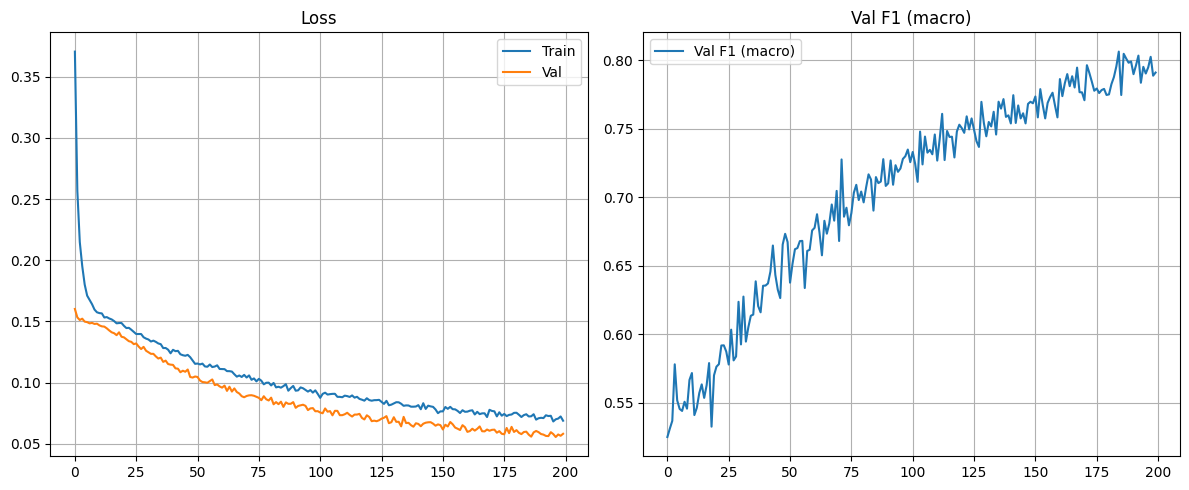

✓ Learned temperature on validation: T = 0.437

📊 Holdout Classification Report
              precision    recall  f1-score   support

     oestrus       0.49      0.93      0.64       247
          OK       0.99      0.89      0.94      2304

    accuracy                           0.90      2551
   macro avg       0.74      0.91      0.79      2551
weighted avg       0.94      0.90      0.91      2551



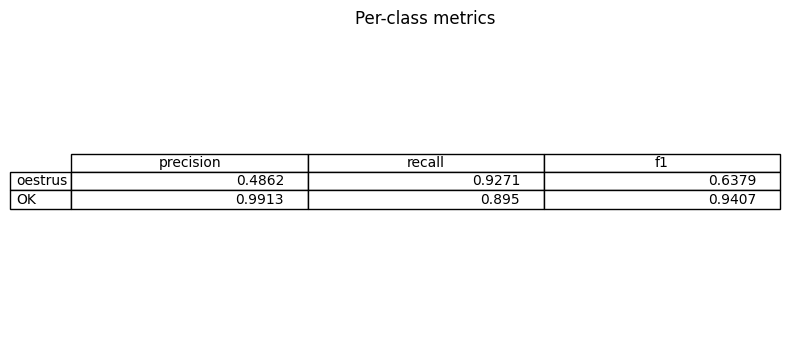

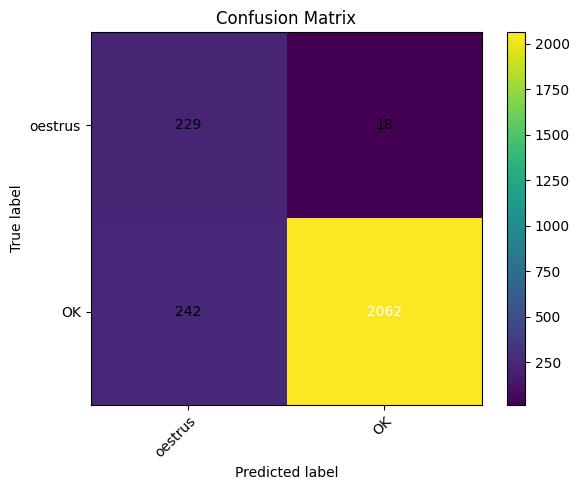


Summary:
  Accuracy      : 0.8981
  F1 (macro)    : 0.7893
  F1 (weighted) : 0.9114
Unique predicted classes on HOLDOUT: [0 1]


In [8]:
# -*- coding: utf-8 -*-
# Robust MLP pipeline with label cleaning (NaN + all-zero handling),
# target/one-hot auto-detection, feature alignment, focal loss, temp scaling.

import os, math, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_fscore_support,
                             accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **k): return x

warnings.filterwarnings("ignore")

# ======================= CONFIG =======================
INCLUDE_CALVING = True          # 6 classes with 'calving'; set False for 5 classes (calving rows removed)
PREFER_TARGET_COLUMN = True     # use df['target'] if valid (0..C-1)
ALL_ZERO_POLICY = "drop"        # 'drop' | 'map_to_ok' | 'error'
NAN_POLICY = "drop"             # 'drop' | 'error'

TRAINVAL_PATH = Path(r"C:/Users/lamia/Downloads/non_augmented_dataset3_trainval.csv")
HOLDOUT_PATH  = Path(r"C:/Users/lamia/Downloads/non_augmented_dataset3_holdout.csv")

SEED = 42
VAL_SIZE = 0.15

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.5, 0.4, 0.3]
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128
LR           = 5e-4
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
LEARN_TEMP   = True

# ======================= UTILS =======================
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def freeze_label_order(include_calving=True):
    if include_calving:
        label_cols = ['oestrus','OK']
    else:
        label_cols = ['oestrus','OK']
    idx2name = {i: c for i, c in enumerate(label_cols)}
    name2idx = {c: i for i, c in enumerate(label_cols)}
    return label_cols, idx2name, name2idx

def optionally_drop_calving(df, include_calving: bool):
    df = df.copy()
    if include_calving:
        return df
    if 'calving' in df.columns:
        before = len(df)
        df = df[df['calving'] == 0].copy()
        print(f"[INFO] Removed {before-len(df)} rows with calving==1 for 5-class setup.")
    return df

def _validate_target_column(df, n_classes):
    if 'target' not in df.columns:
        return False
    col = df['target']
    if col.isna().any():
        return False
    vals = col.astype(float)
    if not np.all(np.isfinite(vals)): return False
    if not np.all(np.equal(vals, np.floor(vals))): return False
    vals = vals.astype(int)
    if (vals.min() < 0) or (vals.max() >= n_classes): return False
    return True

def _one_hot_sanity(df, label_cols):
    sub = df[label_cols].astype(float)
    row_sums = sub.sum(axis=1)
    bad_all_zero  = int((row_sums == 0).sum())
    bad_multi_hot = int((row_sums > 1.0 + 1e-9).sum())
    bad_nans      = int(sub.isna().any(axis=1).sum())
    dist = sub.idxmax(axis=1).value_counts(dropna=False).sort_index()
    return bad_all_zero, bad_multi_hot, bad_nans, dist

def coerce_one_hot_numeric(df, label_cols):
    """
    Try to coerce a possibly stringy 'one-hot' block into numeric 0/1.
    Rules per cell:
      - numeric -> kept (0/1 expected, but any number allowed until sanity check)
      - string equal to its column name (case-insensitive, trimmed) -> 1
      - '1','true','yes' -> 1
      - '0','false','no','' (empty) -> 0
      - otherwise -> NaN (so NaN policy can handle)
    """
    sub = df[label_cols].copy()

    # Fast path: already numeric
    if np.all(sub.dtypes.apply(lambda t: np.issubdtype(t, np.number))):
        return sub.astype(float)

    def to01(col_series, col_name):
        s = col_series.astype(str).str.strip()
        lower = s.str.lower()

        is_colname = lower == col_name.lower()
        is_one  = lower.isin(["1", "true", "yes", "y"])
        is_zero = lower.isin(["0", "false", "no", "n", "nan", "none", ""])

        out = pd.Series(np.nan, index=s.index, dtype=float)
        out[is_colname | is_one] = 1.0
        out[is_zero]             = 0.0

        # If original dtype was numeric for some rows, preserve those values
        # (helps when a column is mixed types)
        mask_numeric = pd.to_numeric(col_series, errors="coerce").notna()
        out.loc[mask_numeric] = pd.to_numeric(col_series.loc[mask_numeric], errors="coerce")

        return out

    coerced = pd.DataFrame(index=sub.index, columns=label_cols, dtype=float)
    for c in label_cols:
        coerced[c] = to01(sub[c], c)

    return coerced


def extract_labels(df, label_cols, class_order=None,
                   all_zero_policy="drop", nan_policy="drop", prefer_target=True):
    """
    Supports:
      - Single label column (class names or ints)  --> map to ids
      - Multi-column one-hot (numeric or stringy)  --> coerce to numeric then argmax
      - Optional integer 'target' (0..C-1) if prefer_target=True
    """
    df = df.copy()

    # Single label column mode
    if len(label_cols) == 1:
        col = label_cols[0]
        if prefer_target and 'target' in df.columns:
            vals = df['target']
            if vals.notna().all() and np.equal(vals, np.floor(vals)).all():
                vals = vals.astype(int)
                if class_order is None or (0 <= vals.min() and vals.max() < len(class_order)):
                    return vals.values, df, {"used": "target_single"}

        lab = df[col]
        if nan_policy == "drop" and lab.isna().any():
            before = len(df); df = df[lab.notna()].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in '{col}'.")
            lab = df[col]
        elif lab.isna().any():
            raise ValueError(f"NaN found in '{col}'. Set NAN_POLICY='drop' to drop them.")

        # Map strings to ids using provided class_order
        if lab.dtype == object or isinstance(lab.iloc[0], str):
            assert class_order is not None, "Provide class_order to map string labels to ids."
            name2idx = {n: i for i, n in enumerate(class_order)}
            y = lab.astype(str).str.strip().map(name2idx)
            if y.isna().any():
                unknown = df.loc[y.isna(), col].unique()
                raise ValueError(f"Unknown label names: {unknown}. Update class_order or clean data.")
            return y.values.astype(int), df, {"used": "single_str"}
        else:
            return lab.astype(int).values, df, {"used": "single_int"}

    # Multi-column one-hot mode
    for c in label_cols:
        if c not in df.columns:
            raise ValueError(f"Missing label column '{c}'.")

    # Prefer integer target if valid
    if prefer_target and 'target' in df.columns:
        col = df['target']
        if col.notna().all() and np.equal(col, np.floor(col)).all():
            vals = col.astype(int)
            if 0 <= vals.min() and vals.max() < len(label_cols):
                return vals.values, df, {"used": "target_onehot"}

    # Coerce to numeric 0/1 if needed
    sub = coerce_one_hot_numeric(df, label_cols)

    # Handle NaNs
    if sub.isna().any(axis=1).any():
        if nan_policy == "drop":
            before = len(df)
            mask = ~sub.isna().any(axis=1)
            df  = df.loc[mask].copy()
            sub = sub.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in label block after coercion.")
        else:
            raise ValueError("NaN in label columns after coercion. Set NAN_POLICY='drop'.")

    # One-hot sanity
    row_sums = sub.sum(axis=1).values
    bad_multi = int((row_sums > 1.0 + 1e-9).sum())
    bad_zero  = int((row_sums == 0).sum())

    if bad_multi > 0:
        raise ValueError("Found multi-hot rows; labels must be strictly one-hot.")

    if bad_zero > 0:
        if all_zero_policy == "drop":
            before = len(df)
            keep = row_sums > 0
            df  = df.loc[keep].copy()
            sub = sub.loc[keep].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with all-zero labels.")
        elif all_zero_policy == "map_to_ok":
            if 'OK' not in label_cols:
                raise ValueError("'map_to_ok' chosen but 'OK' not in label_cols.")
            mask0 = (row_sums == 0)
            sub.loc[mask0, 'OK'] = 1.0
            print(f"[INFO] Mapped {int(mask0.sum())} all-zero rows to OK=1.")
        else:
            raise ValueError("All-zero labels; set ALL_ZERO_POLICY='drop' or 'map_to_ok'.")

    y = sub.values.argmax(axis=1)
    return y, df, {"used": "one_hot_coerced"}

def ensure_feature_alignment(df, feature_names):
    missing = [c for c in feature_names if c not in df.columns]
    for c in missing:
        df[c] = 0.0
    return df[feature_names].astype(float)

# ======================= MODEL =======================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes,
                 dropout_rates=None, activation='relu', use_batchnorm=True):
        super().__init__()
        if dropout_rates is None: dropout_rates = [0.4] * len(hidden_dims)
        act_map = {
            'relu': nn.ReLU, 'leakyrelu': lambda: nn.LeakyReLU(0.1),
            'gelu': nn.GELU, 'elu': nn.ELU
        }
        Act = act_map.get(activation.lower(), nn.ReLU)

        layers = []
        prev = input_dim
        for h, dr in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm: layers.append(nn.BatchNorm1d(h))
            layers.append(Act())
            if dr and dr > 0: layers.append(nn.Dropout(dr))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super().__init__()
        self.weight = weight; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, target):
        ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp(1e-6, 1-1e-6)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class _TempScaler(nn.Module):
    def __init__(self, init_T=1.0):
        super().__init__()
        self.logT = nn.Parameter(torch.tensor([math.log(init_T)], dtype=torch.float32))
    def forward(self, logits): return logits / torch.exp(self.logT)
    @property
    def T(self): return float(torch.exp(self.logT).item())

def learn_temperature(model, val_loader, init_T=1.0, max_iter=100, lr=0.01, weight=None):
    model.eval()
    temp = _TempScaler(init_T)
    opt = optim.LBFGS(temp.parameters(), lr=lr, max_iter=max_iter)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    with torch.no_grad():
        logits_list, labels_list = [], []
        for xb, yb in val_loader:
            logits_list.append(model(xb))
            labels_list.append(yb)
        logits = torch.cat(logits_list, 0)
        labels = torch.cat(labels_list, 0)
    def closure():
        opt.zero_grad()
        loss = loss_fn(temp(logits), labels)
        loss.backward()
        return loss
    opt.step(closure)
    return temp.T

# ======================= DATA & TRAIN =======================
def split_fit_scaler(df, label_cols, drop_cols=None, val_size=0.15, random_state=42):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )

    feature_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feature_names = feature_df.columns.tolist()

    X_train, X_val, y_train, y_val = train_test_split(
        feature_df.values, y, test_size=val_size, random_state=random_state, stratify=y
    )
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val   = scaler.transform(X_val)
    return X_train, y_train, X_val, y_val, scaler, feature_names

def make_loaders_from_arrays(X_train, y_train, X_val, y_val, batch_size=128):
    def td(x, y): return TensorDataset(torch.tensor(x, dtype=torch.float32),
                                       torch.tensor(y, dtype=torch.long))
    train_loader = DataLoader(td(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(td(X_val,   y_val),   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def class_weights_from_train(y_train, n_classes):
    w = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
    return torch.tensor(w, dtype=torch.float32)

def train_on_trainval(
    df_trainval, label_cols, drop_cols=None,
    hidden_dims=HIDDEN_DIMS, dropout_rates=DROPOUTS,
    activation=ACTIVATION, use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE, lr=LR, weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS, patience=PATIENCE, min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL, learn_temp=LEARN_TEMP
):
    set_seed(SEED)
    X_tr, y_tr, X_val, y_val, scaler, feature_names = split_fit_scaler(
        df_trainval, label_cols, drop_cols, val_size=VAL_SIZE, random_state=SEED
    )
    n_classes = len(label_cols)
    train_loader, val_loader = make_loaders_from_arrays(X_tr, y_tr, X_val, y_val, batch_size=batch_size)
    class_w = class_weights_from_train(y_tr, n_classes)

    model = CowHealthMLP(
        input_dim=len(feature_names), hidden_dims=hidden_dims, num_classes=n_classes,
        dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm
    )

    criterion = FocalLoss(weight=class_w) if use_focal_loss else nn.CrossEntropyLoss(weight=class_w)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5)

    best_val, best_state = float('inf'), None
    train_loss_hist, val_loss_hist, val_f1_hist = [], [], []
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * xb.size(0)
        run_loss /= len(train_loader.dataset)
        train_loss_hist.append(run_loss)

        model.eval()
        vloss, vpreds, vlabels = 0.0, [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                out = model(xb)
                loss = criterion(out, yb)
                vloss += loss.item() * xb.size(0)
                vpreds.extend(out.argmax(1).cpu().numpy())
                vlabels.extend(yb.cpu().numpy())
        vloss /= len(val_loader.dataset)
        val_loss_hist.append(vloss)
        val_f1 = f1_score(vlabels, vpreds, average='macro')
        val_f1_hist.append(val_f1)
        scheduler.step(vloss)

        uniq = np.unique(vpreds)
        if uniq.size == 1:
            print(f"[epoch {epoch+1}] WARNING: only predicted class {uniq[0]} on VAL — check imbalance.")

        if vloss < best_val - min_delta:
            best_val, best_state = vloss, model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_loss_hist,label='Train'); plt.plot(val_loss_hist,label='Val')
    plt.title('Loss'); plt.grid(); plt.legend()
    plt.subplot(1,2,2); plt.plot(val_f1_hist,label='Val F1 (macro)')
    plt.title('Val F1 (macro)'); plt.grid(); plt.legend()
    plt.tight_layout(); plt.show()

    T = 1.0
    if learn_temp:
        T = learn_temperature(model, val_loader, init_T=1.0, lr=0.01, max_iter=100, weight=class_w)
        print(f"✓ Learned temperature on validation: T = {T:.3f}")

    return model, scaler, T, feature_names

# ======================= EVAL =======================
def transform_with_scaler(df, label_cols, drop_cols, scaler, feature_names):
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )
    feat_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feat_df = ensure_feature_alignment(feat_df, feature_names)
    X = scaler.transform(feat_df.values)
    return X, y

def plot_per_class_metrics(y_true, y_pred, class_names):
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
    table = pd.DataFrame({'precision': pr, 'recall': rc, 'f1': f1}, index=class_names)
    ax.axis('off'); ax.table(cellText=np.round(table.values, 4), colLabels=table.columns,
                             rowLabels=table.index, loc='center')
    ax.set_title("Per-class metrics"); plt.tight_layout(); plt.show()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

def print_f1_summary(y_true, y_pred):
    print("\nSummary:")
    print(f"  Accuracy      : {accuracy_score(y_true, y_pred):.4f}")
    print(f"  F1 (macro)    : {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"  F1 (weighted) : {f1_score(y_true, y_pred, average='weighted'):.4f}")

def evaluate_on_holdout(model, scaler, df_holdout, label_cols, drop_cols=None,
                        feature_names=None, temperature=1.0, batch_size=128):
    model.eval()
    X_test, y_test = transform_with_scaler(df_holdout, label_cols, drop_cols, scaler, feature_names)
    ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb) / temperature
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\n📊 Holdout Classification Report")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)
    print("Unique predicted classes on HOLDOUT:", np.unique(all_preds))

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

# ======================= MAIN =======================
if __name__ == "__main__":
    set_seed(SEED)

    FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(include_calving=INCLUDE_CALVING)

    df_trainval = pd.read_csv(TRAINVAL_PATH)
    df_holdout  = pd.read_csv(HOLDOUT_PATH)

    df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
    df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

    drop_cols = ['cow','start_time','end_time']
    if 'calving' in df_trainval.columns and 'calving' not in drop_cols:
        drop_cols.append('calving')

    model, scaler, T, feature_names = train_on_trainval(
        df_trainval,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        hidden_dims=HIDDEN_DIMS,
        dropout_rates=DROPOUTS,
        activation=ACTIVATION,
        use_batchnorm=USE_BN,
        batch_size=BATCH_SIZE,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        epochs=EPOCHS,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
        use_focal_loss=USE_FOCAL,
        learn_temp=LEARN_TEMP
    )

    _ = evaluate_on_holdout(
        model, scaler, df_holdout,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        feature_names=feature_names,
        temperature=T,
        batch_size=BATCH_SIZE
    )


[DEBUG] y_tr distribution: Counter({5: 133396, 1: 1008, 0: 944, 2: 638, 4: 514, 3: 182})
[DEBUG] y_val distribution: Counter({5: 23541, 1: 178, 0: 167, 2: 112, 4: 91, 3: 32})
[DEBUG] n_features: 23
[DEBUG] any NaNs in X_tr/X_val: False False


Training:   0%|          | 0/200 [00:00<?, ?it/s]

[DEBUG] val logits mean/std per class (first batch): [-4.084 -5.655 -3.438 -6.084 -4.243 -4.063] [1.578 1.363 1.106 1.601 1.147 1.135]


Training:   0%|          | 1/200 [00:32<1:48:58, 32.85s/it]

[epoch 001] train_loss=2.7834 | val_loss=0.6424 | val_f1=0.0755


Training:   1%|          | 2/200 [01:05<1:47:26, 32.56s/it]

[epoch 002] train_loss=1.7644 | val_loss=0.5736 | val_f1=0.0735


Training:   2%|▏         | 3/200 [01:38<1:47:32, 32.75s/it]

[epoch 003] train_loss=1.4773 | val_loss=0.4886 | val_f1=0.1034


Training:   2%|▏         | 4/200 [02:09<1:45:10, 32.20s/it]

[epoch 004] train_loss=1.3029 | val_loss=0.4703 | val_f1=0.0989


Training:   2%|▎         | 5/200 [02:44<1:48:04, 33.25s/it]

[epoch 005] train_loss=1.1733 | val_loss=0.4388 | val_f1=0.0963


Training:   3%|▎         | 6/200 [03:17<1:47:33, 33.26s/it]

[epoch 006] train_loss=1.1018 | val_loss=0.4370 | val_f1=0.1022


Training:   4%|▎         | 7/200 [03:51<1:47:35, 33.45s/it]

[epoch 007] train_loss=0.9696 | val_loss=0.4220 | val_f1=0.1127


Training:   4%|▍         | 8/200 [04:27<1:49:06, 34.10s/it]

[epoch 008] train_loss=0.9235 | val_loss=0.3753 | val_f1=0.1053


Training:   4%|▍         | 9/200 [04:59<1:46:25, 33.43s/it]

[epoch 009] train_loss=0.8491 | val_loss=0.3348 | val_f1=0.1278


Training:   5%|▌         | 10/200 [05:29<1:43:06, 32.56s/it]

[epoch 010] train_loss=0.8245 | val_loss=0.3322 | val_f1=0.1240


Training:   6%|▌         | 11/200 [06:00<1:40:31, 31.92s/it]

[epoch 011] train_loss=0.7702 | val_loss=0.3499 | val_f1=0.1159


Training:   6%|▌         | 12/200 [06:33<1:41:00, 32.24s/it]

[epoch 012] train_loss=0.7195 | val_loss=0.3483 | val_f1=0.1217


Training:   6%|▋         | 13/200 [07:03<1:38:23, 31.57s/it]

[epoch 013] train_loss=0.6922 | val_loss=0.3068 | val_f1=0.1327


Training:   7%|▋         | 14/200 [07:39<1:42:40, 33.12s/it]

[epoch 014] train_loss=0.6752 | val_loss=0.3275 | val_f1=0.1332


Training:   8%|▊         | 15/200 [08:07<1:37:11, 31.52s/it]

[epoch 015] train_loss=0.6535 | val_loss=0.3052 | val_f1=0.1256


Training:   8%|▊         | 16/200 [08:40<1:37:27, 31.78s/it]

[epoch 016] train_loss=0.6270 | val_loss=0.2728 | val_f1=0.1322


Training:   8%|▊         | 17/200 [09:09<1:34:32, 31.00s/it]

[epoch 017] train_loss=0.5767 | val_loss=0.2614 | val_f1=0.1423


Training:   9%|▉         | 18/200 [09:41<1:34:50, 31.27s/it]

[epoch 018] train_loss=0.5580 | val_loss=0.3072 | val_f1=0.1370


Training:  10%|▉         | 19/200 [10:11<1:33:16, 30.92s/it]

[epoch 019] train_loss=0.5574 | val_loss=0.2757 | val_f1=0.1444


Training:  10%|█         | 20/200 [10:41<1:32:26, 30.81s/it]

[epoch 020] train_loss=0.5171 | val_loss=0.2726 | val_f1=0.1500


Training:  10%|█         | 21/200 [11:12<1:31:46, 30.76s/it]

[epoch 021] train_loss=0.5216 | val_loss=0.2561 | val_f1=0.1402


Training:  11%|█         | 22/200 [11:43<1:31:18, 30.78s/it]

[epoch 022] train_loss=0.5080 | val_loss=0.2829 | val_f1=0.1417


Training:  12%|█▏        | 23/200 [12:12<1:29:33, 30.36s/it]

[epoch 023] train_loss=0.5215 | val_loss=0.2484 | val_f1=0.1454


Training:  12%|█▏        | 24/200 [12:50<1:35:52, 32.69s/it]

[epoch 024] train_loss=0.4820 | val_loss=0.2650 | val_f1=0.1444


Training:  12%|█▎        | 25/200 [13:21<1:33:18, 31.99s/it]

[epoch 025] train_loss=0.4686 | val_loss=0.2458 | val_f1=0.1557


Training:  13%|█▎        | 26/200 [13:56<1:35:24, 32.90s/it]

[epoch 026] train_loss=0.4391 | val_loss=0.2652 | val_f1=0.1584


Training:  14%|█▎        | 27/200 [14:25<1:31:41, 31.80s/it]

[epoch 027] train_loss=0.4755 | val_loss=0.2452 | val_f1=0.1536


Training:  14%|█▍        | 28/200 [14:59<1:32:44, 32.35s/it]

[epoch 028] train_loss=0.4475 | val_loss=0.2543 | val_f1=0.1542


Training:  14%|█▍        | 29/200 [15:30<1:31:01, 31.94s/it]

[epoch 029] train_loss=0.4335 | val_loss=0.2929 | val_f1=0.1556


Training:  15%|█▌        | 30/200 [16:02<1:30:31, 31.95s/it]

[epoch 030] train_loss=0.4205 | val_loss=0.2798 | val_f1=0.1595


Training:  16%|█▌        | 31/200 [16:32<1:28:43, 31.50s/it]

[epoch 031] train_loss=0.4169 | val_loss=0.2160 | val_f1=0.1635


Training:  16%|█▌        | 32/200 [17:00<1:25:22, 30.49s/it]

[epoch 032] train_loss=0.4003 | val_loss=0.2261 | val_f1=0.1639


Training:  16%|█▋        | 33/200 [17:37<1:30:30, 32.52s/it]

[epoch 033] train_loss=0.4208 | val_loss=0.2133 | val_f1=0.1577


Training:  17%|█▋        | 34/200 [18:06<1:26:56, 31.43s/it]

[epoch 034] train_loss=0.3994 | val_loss=0.2393 | val_f1=0.1623


Training:  18%|█▊        | 35/200 [18:38<1:26:49, 31.57s/it]

[epoch 035] train_loss=0.4203 | val_loss=0.2232 | val_f1=0.1656


Training:  18%|█▊        | 36/200 [19:09<1:26:01, 31.47s/it]

[epoch 036] train_loss=0.4087 | val_loss=0.2552 | val_f1=0.1571


Training:  18%|█▊        | 37/200 [19:43<1:27:10, 32.09s/it]

[epoch 037] train_loss=0.3829 | val_loss=0.2463 | val_f1=0.1584


Training:  19%|█▉        | 38/200 [20:13<1:24:48, 31.41s/it]

[epoch 038] train_loss=0.4136 | val_loss=0.2183 | val_f1=0.1630


Training:  20%|█▉        | 39/200 [20:41<1:22:01, 30.57s/it]

[epoch 039] train_loss=0.3659 | val_loss=0.2411 | val_f1=0.1600


Training:  20%|██        | 40/200 [21:09<1:18:57, 29.61s/it]

[epoch 040] train_loss=0.3711 | val_loss=0.2264 | val_f1=0.1568


Training:  20%|██        | 41/200 [21:40<1:19:29, 30.00s/it]

[epoch 041] train_loss=0.3677 | val_loss=0.2529 | val_f1=0.1545


Training:  21%|██        | 42/200 [22:09<1:18:28, 29.80s/it]

[epoch 042] train_loss=0.3690 | val_loss=0.2368 | val_f1=0.1652


Training:  22%|██▏       | 43/200 [22:42<1:20:36, 30.80s/it]

[epoch 043] train_loss=0.3625 | val_loss=0.2416 | val_f1=0.1589


Training:  22%|██▏       | 44/200 [23:12<1:19:40, 30.64s/it]

[epoch 044] train_loss=0.3440 | val_loss=0.2367 | val_f1=0.1605


Training:  22%|██▎       | 45/200 [23:45<1:20:59, 31.35s/it]

[epoch 045] train_loss=0.3715 | val_loss=0.2250 | val_f1=0.1603


Training:  23%|██▎       | 46/200 [24:11<1:15:59, 29.61s/it]

[epoch 046] train_loss=0.3635 | val_loss=0.2168 | val_f1=0.1746


Training:  24%|██▎       | 47/200 [24:37<1:12:32, 28.45s/it]

[epoch 047] train_loss=0.3484 | val_loss=0.2178 | val_f1=0.1693


Training:  24%|██▍       | 48/200 [25:08<1:14:06, 29.25s/it]

[epoch 048] train_loss=0.3450 | val_loss=0.2317 | val_f1=0.1660


Training:  24%|██▍       | 49/200 [25:36<1:13:00, 29.01s/it]

[epoch 049] train_loss=0.3390 | val_loss=0.2191 | val_f1=0.1758


Training:  25%|██▌       | 50/200 [26:07<1:13:36, 29.45s/it]

[epoch 050] train_loss=0.3425 | val_loss=0.2249 | val_f1=0.1732


Training:  26%|██▌       | 51/200 [26:33<1:10:46, 28.50s/it]

[epoch 051] train_loss=0.3536 | val_loss=0.2180 | val_f1=0.1740


Training:  26%|██▌       | 52/200 [27:04<1:12:00, 29.19s/it]

[epoch 052] train_loss=0.3311 | val_loss=0.2053 | val_f1=0.1767


Training:  26%|██▋       | 53/200 [27:36<1:13:23, 29.95s/it]

[epoch 053] train_loss=0.3232 | val_loss=0.2209 | val_f1=0.1758


Training:  27%|██▋       | 54/200 [28:03<1:10:49, 29.11s/it]

[epoch 054] train_loss=0.3455 | val_loss=0.2285 | val_f1=0.1807


Training:  28%|██▊       | 55/200 [28:30<1:08:40, 28.42s/it]

[epoch 055] train_loss=0.3058 | val_loss=0.2231 | val_f1=0.1761


Training:  28%|██▊       | 56/200 [29:00<1:09:30, 28.96s/it]

[epoch 056] train_loss=0.3123 | val_loss=0.1853 | val_f1=0.1796


Training:  28%|██▊       | 57/200 [29:35<1:13:25, 30.81s/it]

[epoch 057] train_loss=0.3140 | val_loss=0.2292 | val_f1=0.1893


Training:  29%|██▉       | 58/200 [30:07<1:13:54, 31.23s/it]

[epoch 058] train_loss=0.3402 | val_loss=0.1982 | val_f1=0.1828


Training:  30%|██▉       | 59/200 [30:39<1:13:44, 31.38s/it]

[epoch 059] train_loss=0.3259 | val_loss=0.2416 | val_f1=0.1727


Training:  30%|███       | 60/200 [31:08<1:11:38, 30.70s/it]

[epoch 060] train_loss=0.3201 | val_loss=0.2160 | val_f1=0.1716


Training:  30%|███       | 61/200 [31:39<1:11:21, 30.81s/it]

[epoch 061] train_loss=0.3040 | val_loss=0.2023 | val_f1=0.1830


Training:  31%|███       | 62/200 [32:10<1:11:19, 31.01s/it]

[epoch 062] train_loss=0.3214 | val_loss=0.2255 | val_f1=0.1755


Training:  32%|███▏      | 63/200 [32:45<1:12:55, 31.93s/it]

[epoch 063] train_loss=0.3207 | val_loss=0.2247 | val_f1=0.1806


Training:  32%|███▏      | 64/200 [33:15<1:11:25, 31.51s/it]

[epoch 064] train_loss=0.3176 | val_loss=0.2189 | val_f1=0.1783


Training:  32%|███▎      | 65/200 [33:46<1:10:48, 31.47s/it]

[epoch 065] train_loss=0.2884 | val_loss=0.2250 | val_f1=0.1822


Training:  33%|███▎      | 66/200 [34:16<1:08:47, 30.80s/it]

[epoch 066] train_loss=0.2956 | val_loss=0.2481 | val_f1=0.1845


Training:  34%|███▎      | 67/200 [34:47<1:08:43, 31.00s/it]

[epoch 067] train_loss=0.3028 | val_loss=0.2347 | val_f1=0.1853


Training:  34%|███▍      | 68/200 [35:14<1:05:22, 29.72s/it]

[epoch 068] train_loss=0.2922 | val_loss=0.2054 | val_f1=0.1704


Training:  34%|███▍      | 69/200 [35:44<1:05:16, 29.90s/it]

[epoch 069] train_loss=0.3030 | val_loss=0.2053 | val_f1=0.1790


Training:  35%|███▌      | 70/200 [36:14<1:04:57, 29.98s/it]

[epoch 070] train_loss=0.3087 | val_loss=0.1927 | val_f1=0.1915


Training:  36%|███▌      | 71/200 [36:43<1:03:51, 29.70s/it]

[epoch 071] train_loss=0.3078 | val_loss=0.2281 | val_f1=0.1803


Training:  36%|███▌      | 72/200 [37:12<1:02:54, 29.48s/it]

[epoch 072] train_loss=0.3054 | val_loss=0.1819 | val_f1=0.1926


Training:  36%|███▋      | 73/200 [37:43<1:02:48, 29.67s/it]

[epoch 073] train_loss=0.3035 | val_loss=0.2117 | val_f1=0.1817


Training:  37%|███▋      | 74/200 [38:14<1:03:15, 30.12s/it]

[epoch 074] train_loss=0.2718 | val_loss=0.1996 | val_f1=0.1950


Training:  38%|███▊      | 75/200 [38:43<1:01:57, 29.74s/it]

[epoch 075] train_loss=0.2700 | val_loss=0.2151 | val_f1=0.1808


Training:  38%|███▊      | 76/200 [39:15<1:03:20, 30.65s/it]

[epoch 076] train_loss=0.2649 | val_loss=0.2040 | val_f1=0.1876


Training:  38%|███▊      | 77/200 [39:47<1:03:14, 30.85s/it]

[epoch 077] train_loss=0.2893 | val_loss=0.2185 | val_f1=0.1874


Training:  39%|███▉      | 78/200 [40:19<1:03:33, 31.26s/it]

[epoch 078] train_loss=0.2781 | val_loss=0.2036 | val_f1=0.1936


Training:  40%|███▉      | 79/200 [40:47<1:01:07, 30.31s/it]

[epoch 079] train_loss=0.2884 | val_loss=0.1910 | val_f1=0.1878


Training:  40%|████      | 80/200 [41:19<1:01:38, 30.82s/it]

[epoch 080] train_loss=0.2782 | val_loss=0.1852 | val_f1=0.1850


Training:  40%|████      | 81/200 [41:47<59:40, 30.09s/it]  

[epoch 081] train_loss=0.2692 | val_loss=0.1918 | val_f1=0.1900


Training:  41%|████      | 82/200 [42:16<58:19, 29.66s/it]

[epoch 082] train_loss=0.2831 | val_loss=0.2112 | val_f1=0.1843


Training:  42%|████▏     | 83/200 [42:45<57:40, 29.57s/it]

[epoch 083] train_loss=0.2879 | val_loss=0.2360 | val_f1=0.1802


Training:  42%|████▏     | 84/200 [43:17<58:29, 30.25s/it]

[epoch 084] train_loss=0.2777 | val_loss=0.2008 | val_f1=0.1969


Training:  42%|████▎     | 85/200 [43:49<58:52, 30.71s/it]

[epoch 085] train_loss=0.2800 | val_loss=0.2009 | val_f1=0.1906


Training:  43%|████▎     | 86/200 [44:17<56:39, 29.82s/it]

[epoch 086] train_loss=0.2632 | val_loss=0.2125 | val_f1=0.1957


Training:  44%|████▎     | 87/200 [44:51<58:42, 31.17s/it]

[epoch 087] train_loss=0.2616 | val_loss=0.1986 | val_f1=0.1839


Training:  44%|████▍     | 88/200 [45:23<58:23, 31.28s/it]

[epoch 088] train_loss=0.2591 | val_loss=0.1966 | val_f1=0.1908


Training:  44%|████▍     | 89/200 [45:57<59:33, 32.19s/it]

[epoch 089] train_loss=0.2516 | val_loss=0.2091 | val_f1=0.1951


Training:  45%|████▌     | 90/200 [46:28<58:23, 31.85s/it]

[epoch 090] train_loss=0.2576 | val_loss=0.1926 | val_f1=0.1939


Training:  46%|████▌     | 91/200 [47:04<1:00:07, 33.09s/it]

[epoch 091] train_loss=0.2465 | val_loss=0.2274 | val_f1=0.1829


Training:  46%|████▌     | 92/200 [47:34<57:59, 32.22s/it]  

[epoch 092] train_loss=0.2737 | val_loss=0.1920 | val_f1=0.1925


Training:  46%|████▋     | 93/200 [48:06<57:09, 32.05s/it]

[epoch 093] train_loss=0.2485 | val_loss=0.1891 | val_f1=0.1967


Training:  47%|████▋     | 94/200 [48:36<55:33, 31.45s/it]

[epoch 094] train_loss=0.2685 | val_loss=0.1823 | val_f1=0.2034


Training:  48%|████▊     | 95/200 [49:08<55:18, 31.61s/it]

[epoch 095] train_loss=0.2605 | val_loss=0.2070 | val_f1=0.1910


Training:  48%|████▊     | 96/200 [49:40<54:51, 31.65s/it]

[epoch 096] train_loss=0.2591 | val_loss=0.1901 | val_f1=0.1891


Training:  48%|████▊     | 97/200 [50:14<55:57, 32.60s/it]

[epoch 097] train_loss=0.2442 | val_loss=0.1887 | val_f1=0.2026


Training:  49%|████▉     | 98/200 [50:43<53:37, 31.54s/it]

[epoch 098] train_loss=0.2565 | val_loss=0.1748 | val_f1=0.2037


Training:  50%|████▉     | 99/200 [51:17<53:54, 32.03s/it]

[epoch 099] train_loss=0.2613 | val_loss=0.2157 | val_f1=0.1905


Training:  50%|█████     | 100/200 [51:43<50:43, 30.43s/it]

[epoch 100] train_loss=0.2664 | val_loss=0.1766 | val_f1=0.1967


Training:  50%|█████     | 101/200 [52:09<48:02, 29.11s/it]

[epoch 101] train_loss=0.2620 | val_loss=0.1867 | val_f1=0.2033


Training:  51%|█████     | 102/200 [52:37<46:37, 28.55s/it]

[epoch 102] train_loss=0.2553 | val_loss=0.2069 | val_f1=0.1967


Training:  52%|█████▏    | 103/200 [52:58<42:53, 26.53s/it]

[epoch 103] train_loss=0.2478 | val_loss=0.2427 | val_f1=0.2009


Training:  52%|█████▏    | 104/200 [53:23<41:17, 25.81s/it]

[epoch 104] train_loss=0.2478 | val_loss=0.1763 | val_f1=0.1983


Training:  52%|█████▎    | 105/200 [53:44<38:35, 24.38s/it]

[epoch 105] train_loss=0.2450 | val_loss=0.1753 | val_f1=0.1974


Training:  53%|█████▎    | 106/200 [54:02<35:33, 22.70s/it]

[epoch 106] train_loss=0.2727 | val_loss=0.1800 | val_f1=0.1956


Training:  54%|█████▎    | 107/200 [54:27<36:01, 23.24s/it]

[epoch 107] train_loss=0.2363 | val_loss=0.1820 | val_f1=0.2009


Training:  54%|█████▍    | 108/200 [54:50<35:25, 23.11s/it]

[epoch 108] train_loss=0.2439 | val_loss=0.1838 | val_f1=0.2039


Training:  55%|█████▍    | 109/200 [55:08<33:00, 21.77s/it]

[epoch 109] train_loss=0.2365 | val_loss=0.1831 | val_f1=0.2066


Training:  55%|█████▌    | 110/200 [55:33<34:08, 22.76s/it]

[epoch 110] train_loss=0.2480 | val_loss=0.1752 | val_f1=0.1934


Training:  56%|█████▌    | 111/200 [55:57<34:20, 23.15s/it]

[epoch 111] train_loss=0.2478 | val_loss=0.1944 | val_f1=0.1970


Training:  56%|█████▌    | 112/200 [56:19<33:13, 22.66s/it]

[epoch 112] train_loss=0.2348 | val_loss=0.2109 | val_f1=0.1912


Training:  56%|█████▋    | 113/200 [56:35<30:11, 20.83s/it]

[epoch 113] train_loss=0.2343 | val_loss=0.1837 | val_f1=0.2136


Training:  57%|█████▋    | 114/200 [56:43<23:56, 16.71s/it]

[epoch 114] train_loss=0.2459 | val_loss=0.1887 | val_f1=0.2091


Training:  57%|█████▊    | 115/200 [56:49<19:28, 13.75s/it]

[epoch 115] train_loss=0.2532 | val_loss=0.1746 | val_f1=0.2108


Training:  58%|█████▊    | 116/200 [56:57<16:26, 11.74s/it]

[epoch 116] train_loss=0.2304 | val_loss=0.2040 | val_f1=0.2002


Training:  58%|█████▊    | 117/200 [57:04<14:22, 10.39s/it]

[epoch 117] train_loss=0.2521 | val_loss=0.2020 | val_f1=0.1963


Training:  59%|█████▉    | 118/200 [57:11<12:57,  9.48s/it]

[epoch 118] train_loss=0.2415 | val_loss=0.1877 | val_f1=0.2005


Training:  60%|█████▉    | 119/200 [57:18<11:50,  8.77s/it]

[epoch 119] train_loss=0.2448 | val_loss=0.1901 | val_f1=0.1981


Training:  60%|██████    | 120/200 [57:25<11:04,  8.30s/it]

[epoch 120] train_loss=0.2497 | val_loss=0.1926 | val_f1=0.1929


Training:  60%|██████    | 121/200 [57:33<10:31,  8.00s/it]

[epoch 121] train_loss=0.2411 | val_loss=0.1819 | val_f1=0.2060


Training:  61%|██████    | 122/200 [57:41<10:39,  8.21s/it]

[epoch 122] train_loss=0.2186 | val_loss=0.1838 | val_f1=0.2016


Training:  62%|██████▏   | 123/200 [57:49<10:10,  7.93s/it]

[epoch 123] train_loss=0.2251 | val_loss=0.2021 | val_f1=0.2031


Training:  62%|██████▏   | 124/200 [57:56<09:46,  7.72s/it]

[epoch 124] train_loss=0.2473 | val_loss=0.1861 | val_f1=0.1909


Training:  62%|██████▎   | 125/200 [58:03<09:28,  7.58s/it]

[epoch 125] train_loss=0.2431 | val_loss=0.2017 | val_f1=0.1981


Training:  63%|██████▎   | 126/200 [58:10<09:08,  7.42s/it]

[epoch 126] train_loss=0.2437 | val_loss=0.1896 | val_f1=0.1996


Training:  64%|██████▎   | 127/200 [58:17<08:53,  7.31s/it]

[epoch 127] train_loss=0.2404 | val_loss=0.1834 | val_f1=0.2051


Training:  64%|██████▍   | 128/200 [58:24<08:42,  7.25s/it]

[epoch 128] train_loss=0.2357 | val_loss=0.2397 | val_f1=0.1942


Training:  64%|██████▍   | 129/200 [58:31<08:31,  7.20s/it]

[epoch 129] train_loss=0.2387 | val_loss=0.1763 | val_f1=0.2133


Training:  65%|██████▌   | 130/200 [58:39<08:21,  7.17s/it]

[epoch 130] train_loss=0.2342 | val_loss=0.1914 | val_f1=0.1967


Training:  66%|██████▌   | 131/200 [58:47<08:43,  7.59s/it]

[epoch 131] train_loss=0.2377 | val_loss=0.1902 | val_f1=0.2009


Training:  66%|██████▌   | 132/200 [58:54<08:25,  7.43s/it]

[epoch 132] train_loss=0.2295 | val_loss=0.1962 | val_f1=0.2019


Training:  66%|██████▋   | 133/200 [59:01<08:12,  7.35s/it]

[epoch 133] train_loss=0.2341 | val_loss=0.1973 | val_f1=0.1990


Training:  67%|██████▋   | 134/200 [59:08<07:59,  7.26s/it]

[epoch 134] train_loss=0.2400 | val_loss=0.1919 | val_f1=0.2001


Training:  68%|██████▊   | 135/200 [59:16<07:49,  7.22s/it]

[epoch 135] train_loss=0.2232 | val_loss=0.1849 | val_f1=0.2107


Training:  68%|██████▊   | 136/200 [59:23<07:39,  7.17s/it]

[epoch 136] train_loss=0.2212 | val_loss=0.2293 | val_f1=0.2080


Training:  68%|██████▊   | 137/200 [59:30<07:32,  7.18s/it]

[epoch 137] train_loss=0.2330 | val_loss=0.2262 | val_f1=0.2064


Training:  69%|██████▉   | 138/200 [59:37<07:22,  7.14s/it]

[epoch 138] train_loss=0.2429 | val_loss=0.1723 | val_f1=0.2087


Training:  70%|██████▉   | 139/200 [59:44<07:15,  7.14s/it]

[epoch 139] train_loss=0.2183 | val_loss=0.1800 | val_f1=0.2201


Training:  70%|███████   | 140/200 [59:52<07:31,  7.53s/it]

[epoch 140] train_loss=0.2128 | val_loss=0.1940 | val_f1=0.2064


Training:  70%|███████   | 141/200 [1:00:00<07:21,  7.49s/it]

[epoch 141] train_loss=0.2247 | val_loss=0.2035 | val_f1=0.2077


Training:  71%|███████   | 142/200 [1:00:07<07:09,  7.40s/it]

[epoch 142] train_loss=0.2427 | val_loss=0.1904 | val_f1=0.2055


Training:  72%|███████▏  | 143/200 [1:00:14<06:59,  7.36s/it]

[epoch 143] train_loss=0.2356 | val_loss=0.1861 | val_f1=0.2039


Training:  72%|███████▏  | 144/200 [1:00:22<06:53,  7.39s/it]

[epoch 144] train_loss=0.2357 | val_loss=0.1849 | val_f1=0.2004


Training:  72%|███████▎  | 145/200 [1:00:52<12:57, 14.13s/it]

[epoch 145] train_loss=0.2292 | val_loss=0.1760 | val_f1=0.2132


Training:  73%|███████▎  | 146/200 [1:01:24<17:36, 19.57s/it]

[epoch 146] train_loss=0.2406 | val_loss=0.1835 | val_f1=0.1927


Training:  74%|███████▎  | 147/200 [1:01:53<19:49, 22.44s/it]

[epoch 147] train_loss=0.2071 | val_loss=0.1911 | val_f1=0.2116


Training:  74%|███████▍  | 148/200 [1:02:21<20:54, 24.13s/it]

[epoch 148] train_loss=0.2238 | val_loss=0.2059 | val_f1=0.2073


Training:  74%|███████▍  | 149/200 [1:02:44<20:13, 23.79s/it]

[epoch 149] train_loss=0.2263 | val_loss=0.1825 | val_f1=0.2266


Training:  75%|███████▌  | 150/200 [1:03:12<20:51, 25.03s/it]

[epoch 150] train_loss=0.2175 | val_loss=0.1858 | val_f1=0.2128


Training:  76%|███████▌  | 151/200 [1:03:34<19:41, 24.11s/it]

[epoch 151] train_loss=0.2351 | val_loss=0.1881 | val_f1=0.2118


Training:  76%|███████▌  | 152/200 [1:03:53<18:10, 22.71s/it]

[epoch 152] train_loss=0.2285 | val_loss=0.1755 | val_f1=0.2118


Training:  76%|███████▋  | 153/200 [1:04:18<18:10, 23.19s/it]

[epoch 153] train_loss=0.2160 | val_loss=0.1775 | val_f1=0.1968


Training:  77%|███████▋  | 154/200 [1:04:44<18:31, 24.16s/it]

[epoch 154] train_loss=0.2215 | val_loss=0.1837 | val_f1=0.2058


Training:  78%|███████▊  | 155/200 [1:05:07<17:56, 23.92s/it]

[epoch 155] train_loss=0.2273 | val_loss=0.1935 | val_f1=0.2129


Training:  78%|███████▊  | 156/200 [1:05:33<17:57, 24.48s/it]

[epoch 156] train_loss=0.2334 | val_loss=0.1807 | val_f1=0.2033


Training:  78%|███████▊  | 157/200 [1:05:58<17:40, 24.66s/it]

[epoch 157] train_loss=0.2125 | val_loss=0.1677 | val_f1=0.2168


Training:  79%|███████▉  | 158/200 [1:06:26<17:49, 25.46s/it]

[epoch 158] train_loss=0.2147 | val_loss=0.1647 | val_f1=0.2006


Training:  80%|███████▉  | 159/200 [1:06:52<17:33, 25.68s/it]

[epoch 159] train_loss=0.2285 | val_loss=0.1730 | val_f1=0.2045


Training:  80%|████████  | 160/200 [1:07:12<15:59, 24.00s/it]

[epoch 160] train_loss=0.2212 | val_loss=0.1731 | val_f1=0.2098


Training:  80%|████████  | 161/200 [1:07:39<16:08, 24.83s/it]

[epoch 161] train_loss=0.2136 | val_loss=0.1876 | val_f1=0.2114


Training:  81%|████████  | 162/200 [1:08:00<15:01, 23.73s/it]

[epoch 162] train_loss=0.2304 | val_loss=0.1880 | val_f1=0.2022


Training:  82%|████████▏ | 163/200 [1:08:19<13:51, 22.47s/it]

[epoch 163] train_loss=0.2077 | val_loss=0.1803 | val_f1=0.2192


Training:  82%|████████▏ | 164/200 [1:08:43<13:46, 22.96s/it]

[epoch 164] train_loss=0.2165 | val_loss=0.1746 | val_f1=0.2143


Training:  82%|████████▎ | 165/200 [1:09:07<13:30, 23.15s/it]

[epoch 165] train_loss=0.2233 | val_loss=0.1605 | val_f1=0.2123


Training:  83%|████████▎ | 166/200 [1:09:29<12:52, 22.72s/it]

[epoch 166] train_loss=0.2083 | val_loss=0.1569 | val_f1=0.2158


Training:  84%|████████▎ | 167/200 [1:09:57<13:23, 24.36s/it]

[epoch 167] train_loss=0.2229 | val_loss=0.2019 | val_f1=0.2093


Training:  84%|████████▍ | 168/200 [1:10:18<12:28, 23.39s/it]

[epoch 168] train_loss=0.2296 | val_loss=0.1799 | val_f1=0.1995


Training:  84%|████████▍ | 169/200 [1:10:39<11:41, 22.64s/it]

[epoch 169] train_loss=0.2253 | val_loss=0.1728 | val_f1=0.2178


Training:  85%|████████▌ | 170/200 [1:11:00<11:03, 22.13s/it]

[epoch 170] train_loss=0.2324 | val_loss=0.1985 | val_f1=0.2087


Training:  86%|████████▌ | 171/200 [1:11:20<10:22, 21.47s/it]

[epoch 171] train_loss=0.2128 | val_loss=0.1801 | val_f1=0.2128


Training:  86%|████████▌ | 172/200 [1:11:42<10:05, 21.63s/it]

[epoch 172] train_loss=0.2217 | val_loss=0.2137 | val_f1=0.2002


Training:  86%|████████▋ | 173/200 [1:12:06<10:06, 22.47s/it]

[epoch 173] train_loss=0.2087 | val_loss=0.2162 | val_f1=0.2164


Training:  87%|████████▋ | 174/200 [1:12:26<09:25, 21.76s/it]

[epoch 174] train_loss=0.2091 | val_loss=0.1765 | val_f1=0.2134


Training:  88%|████████▊ | 175/200 [1:12:49<09:06, 21.87s/it]

[epoch 175] train_loss=0.2098 | val_loss=0.1851 | val_f1=0.2118


Training:  88%|████████▊ | 176/200 [1:13:13<09:00, 22.52s/it]

[epoch 176] train_loss=0.2061 | val_loss=0.2070 | val_f1=0.2183


Training:  88%|████████▊ | 177/200 [1:13:37<08:50, 23.07s/it]

[epoch 177] train_loss=0.2003 | val_loss=0.1890 | val_f1=0.2166


Training:  89%|████████▉ | 178/200 [1:14:03<08:48, 24.00s/it]

[epoch 178] train_loss=0.2047 | val_loss=0.1802 | val_f1=0.2111


Training:  89%|████████▉ | 178/200 [1:14:23<09:11, 25.07s/it]

[epoch 179] train_loss=0.2083 | val_loss=0.1833 | val_f1=0.2097

Early stopping at epoch 179 (no F1 improvement for 30 epochs)


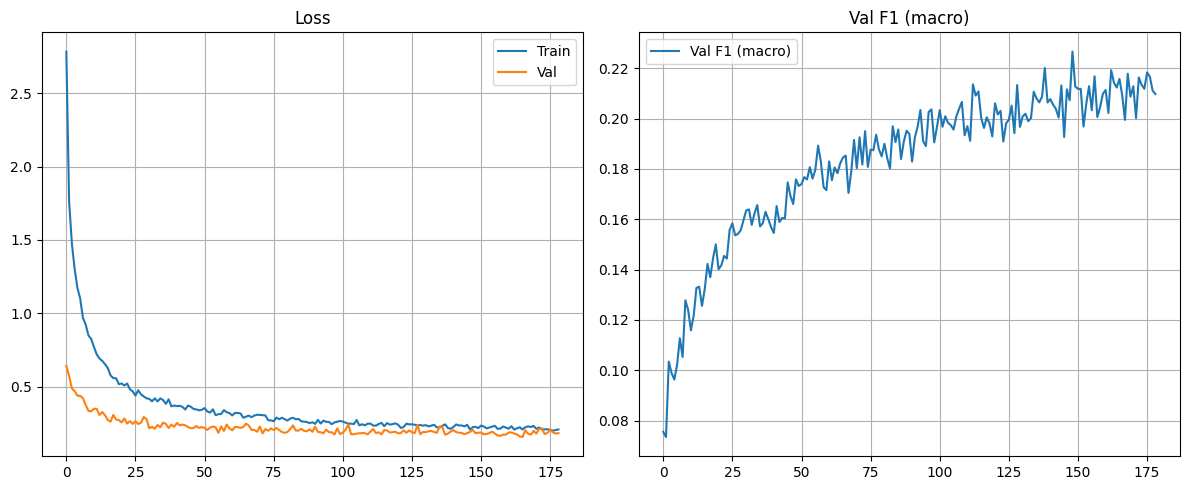

✓ Learned temperature on validation: T = 0.997

📊 Holdout Classification Report
               precision    recall  f1-score   support

      oestrus       0.03      0.98      0.06       124
      calving       0.15      0.99      0.26       132
     lameness       0.04      0.96      0.07        83
     mastitis       0.05      1.00      0.09        24
other_disease       0.05      0.99      0.09        67
           OK       1.00      0.54      0.70     17438

     accuracy                           0.55     17868
    macro avg       0.22      0.91      0.21     17868
 weighted avg       0.98      0.55      0.69     17868



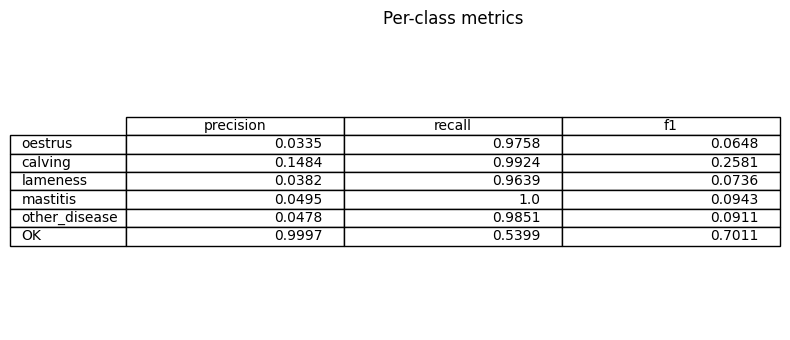

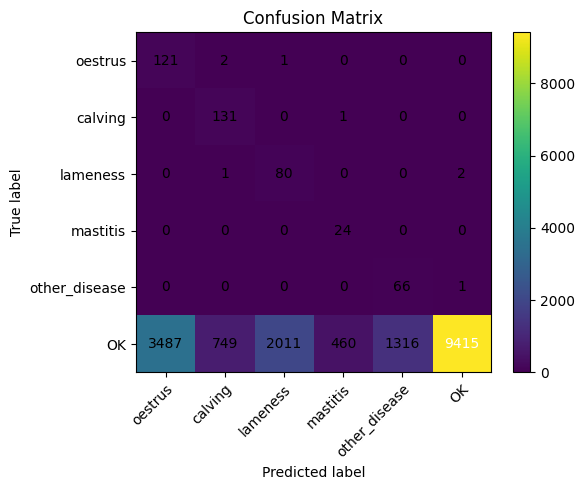


Summary:
  Accuracy      : 0.5505
  F1 (macro)    : 0.2138
  F1 (weighted) : 0.6874
Unique predicted classes on HOLDOUT: [0 1 2 3 4 5]


In [2]:
# -*- coding: utf-8 -*-
# Robust MLP pipeline with label cleaning (NaN + all-zero handling),
# target/one-hot auto-detection, feature alignment, focal loss, temp scaling,
# balanced sampler, prior bias init, early stopping on macro-F1,
# and NaN/Inf-safe imputation + scaling.

import os, math, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_fscore_support,
                             accuracy_score)
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **k): return x

warnings.filterwarnings("ignore")

# ======================= CONFIG =======================
INCLUDE_CALVING = True          # 6 classes with 'calving'; False -> 5 classes (rows with calving==1 removed)
PREFER_TARGET_COLUMN = True     # use df['target'] if valid (0..C-1)
ALL_ZERO_POLICY = "drop"        # 'drop' | 'map_to_ok' | 'error'
NAN_POLICY = "drop"             # 'drop' | 'error'
DROP_CONSTANT_FEATURES = True   # drop zero-variance columns (based on TRAIN after imputation)

TRAINVAL_PATH = Path(r"C:/Users/lamia/Downloads/non_augmented_dataset4_trainval.csv")
HOLDOUT_PATH  = Path(r"C:/Users/lamia/Downloads/non_augmented_dataset4_holdout.csv")

SEED = 42
VAL_SIZE = 0.15

HIDDEN_DIMS = [512, 256, 128]
DROPOUTS    = [0.35, 0.30, 0.25]   # lighter than before
ACTIVATION  = 'leakyrelu'
USE_BN      = True

BATCH_SIZE   = 128                 # smaller batch -> more gradient noise
LR           = 1e-3                # higher LR for better exploration
WEIGHT_DECAY = 1e-4
EPOCHS       = 200
PATIENCE     = 30
MIN_DELTA    = 1e-3
USE_FOCAL    = True
FOCAL_GAMMA  = 1.2                 # was 2.0
LEARN_TEMP   = True

SAMPLER_MAX_RATIO = 4.0            # clip minority upweighting to <= 4x majority for stability

# ======================= UTILS =======================
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def freeze_label_order(include_calving=True):
    if include_calving:
        label_cols = ['oestrus','calving','lameness','mastitis','other_disease','OK']
    else:
        # 5-class list WITHOUT 'calving'
        label_cols = ['oestrus','lameness','mastitis','other_disease','OK']
    idx2name = {i: c for i, c in enumerate(label_cols)}
    name2idx = {c: i for i, c in enumerate(label_cols)}
    return label_cols, idx2name, name2idx

def optionally_drop_calving(df, include_calving: bool):
    df = df.copy()
    if include_calving:
        return df
    if 'calving' in df.columns:
        before = len(df)
        df = df[df['calving'] == 0].copy()
        print(f"[INFO] Removed {before-len(df)} rows with calving==1 for 5-class setup.")
    return df

def _one_hot_sanity(df, label_cols):
    sub = df[label_cols].astype(float)
    row_sums = sub.sum(axis=1)
    bad_all_zero  = int((row_sums == 0).sum())
    bad_multi_hot = int((row_sums > 1.0 + 1e-9).sum())
    bad_nans      = int(sub.isna().any(axis=1).sum())
    dist = sub.idxmax(axis=1).value_counts(dropna=False).sort_index()
    return bad_all_zero, bad_multi_hot, bad_nans, dist

def coerce_one_hot_numeric(df, label_cols):
    sub = df[label_cols].copy()
    if np.all(sub.dtypes.apply(lambda t: np.issubdtype(t, np.number))):
        return sub.astype(float)

    def to01(col_series, col_name):
        s = col_series.astype(str).str.strip()
        lower = s.str.lower()
        is_colname = lower == col_name.lower()
        is_one  = lower.isin(["1", "true", "yes", "y"])
        is_zero = lower.isin(["0", "false", "no", "n", "nan", "none", ""])
        out = pd.Series(np.nan, index=s.index, dtype=float)
        out[is_colname | is_one] = 1.0
        out[is_zero]             = 0.0
        mask_numeric = pd.to_numeric(col_series, errors="coerce").notna()
        out.loc[mask_numeric] = pd.to_numeric(col_series.loc[mask_numeric], errors="coerce")
        return out

    coerced = pd.DataFrame(index=sub.index, columns=label_cols, dtype=float)
    for c in label_cols:
        coerced[c] = to01(sub[c], c)
    return coerced

def extract_labels(df, label_cols, class_order=None,
                   all_zero_policy="drop", nan_policy="drop", prefer_target=True):
    df = df.copy()

    # Single label column mode
    if len(label_cols) == 1:
        col = label_cols[0]
        if prefer_target and 'target' in df.columns:
            vals = df['target']
            if vals.notna().all() and np.equal(vals, np.floor(vals)).all():
                vals = vals.astype(int)
                if class_order is None or (0 <= vals.min() and vals.max() < len(class_order)):
                    return vals.values, df, {"used": "target_single"}
        lab = df[col]
        if nan_policy == "drop" and lab.isna().any():
            before = len(df); df = df[lab.notna()].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in '{col}'.")
            lab = df[col]
        elif lab.isna().any():
            raise ValueError(f"NaN found in '{col}'. Set NAN_POLICY='drop' to drop them.")
        if lab.dtype == object or isinstance(lab.iloc[0], str):
            assert class_order is not None, "Provide class_order to map string labels to ids."
            name2idx = {n: i for i, n in enumerate(class_order)}
            y = lab.astype(str).str.strip().map(name2idx)
            if y.isna().any():
                unknown = df.loc[y.isna(), col].unique()
                raise ValueError(f"Unknown label names: {unknown}. Update class_order or clean data.")
            return y.values.astype(int), df, {"used": "single_str"}
        else:
            return lab.astype(int).values, df, {"used": "single_int"}

    # Multi-column one-hot mode
    for c in label_cols:
        if c not in df.columns:
            raise ValueError(f"Missing label column '{c}'.")

    if prefer_target and 'target' in df.columns:
        col = df['target']
        if col.notna().all() and np.equal(col, np.floor(col)).all():
            vals = col.astype(int)
            if 0 <= vals.min() and vals.max() < len(label_cols):
                return vals.values, df, {"used": "target_onehot"}

    sub = coerce_one_hot_numeric(df, label_cols)

    # Handle NaNs in label block
    if sub.isna().any(axis=1).any():
        if nan_policy == "drop":
            before = len(df)
            mask = ~sub.isna().any(axis=1)
            df  = df.loc[mask].copy()
            sub = sub.loc[mask].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with NaN in label block after coercion.")
        else:
            raise ValueError("NaN in label columns after coercion. Set NAN_POLICY='drop'.")

    # One-hot sanity
    bad_all_zero, bad_multi_hot, bad_nans, dist = _one_hot_sanity(df.assign(**sub), label_cols)
    if bad_multi_hot > 0:
        raise ValueError("Found multi-hot rows; labels must be strictly one-hot.")

    if bad_all_zero > 0:
        if all_zero_policy == "drop":
            before = len(df)
            row_sums = sub.sum(axis=1).values
            keep = row_sums > 0
            df  = df.loc[keep].copy()
            sub = sub.loc[keep].copy()
            print(f"[INFO] Dropped {before-len(df)} rows with all-zero labels.")
        elif all_zero_policy == "map_to_ok":
            if 'OK' not in label_cols:
                raise ValueError("'map_to_ok' chosen but 'OK' not in label_cols.")
            row_sums = sub.sum(axis=1).values
            mask0 = (row_sums == 0)
            sub.loc[mask0, 'OK'] = 1.0
            print(f"[INFO] Mapped {int(mask0.sum())} all-zero rows to OK=1.")
        else:
            raise ValueError("All-zero labels; set ALL_ZERO_POLICY='drop' or 'map_to_ok'.")

    y = sub.values.argmax(axis=1)
    return y, df, {"used": "one_hot_coerced"}

def ensure_feature_alignment(df, feature_names):
    missing = [c for c in feature_names if c not in df.columns]
    for c in missing:
        df[c] = 0.0
    return df[feature_names].astype(float)

# ======================= MODEL =======================
class CowHealthMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes,
                 dropout_rates=None, activation='relu', use_batchnorm=True):
        super().__init__()
        if dropout_rates is None: dropout_rates = [0.4] * len(hidden_dims)
        act_map = {
            'relu': nn.ReLU, 'leakyrelu': lambda: nn.LeakyReLU(0.1),
            'gelu': nn.GELU, 'elu': nn.ELU
        }
        Act = act_map.get(activation.lower(), nn.ReLU)

        layers = []
        prev = input_dim
        for h, dr in zip(hidden_dims, dropout_rates):
            layers.append(nn.Linear(prev, h))
            if use_batchnorm: layers.append(nn.BatchNorm1d(h))
            layers.append(Act())
            if dr and dr > 0: layers.append(nn.Dropout(dr))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)

    def forward(self, x): return self.net(x)

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=FOCAL_GAMMA, reduction='mean'):
        super().__init__()
        self.weight = weight; self.gamma = gamma; self.reduction = reduction
    def forward(self, logits, target):
        ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.softmax(logits, dim=1).gather(1, target.view(-1,1)).squeeze(1).clamp(1e-6, 1-1e-6)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class _TempScaler(nn.Module):
    def __init__(self, init_T=1.0):
        super().__init__()
        self.logT = nn.Parameter(torch.tensor([math.log(init_T)], dtype=torch.float32))
    def forward(self, logits): return logits / torch.exp(self.logT)
    @property
    def T(self): return float(torch.exp(self.logT).item())

def learn_temperature(model, val_loader, init_T=1.0, max_iter=100, lr=0.01, weight=None):
    model.eval()
    temp = _TempScaler(init_T)
    opt = optim.LBFGS(temp.parameters(), lr=lr, max_iter=max_iter)
    loss_fn = nn.CrossEntropyLoss(weight=weight)
    with torch.no_grad():
        logits_list, labels_list = [], []
        for xb, yb in val_loader:
            logits_list.append(model(xb))
            labels_list.append(yb)
        logits = torch.cat(logits_list, 0)
        labels = torch.cat(labels_list, 0)
    def closure():
        opt.zero_grad()
        loss = loss_fn(temp(logits), labels)
        loss.backward()
        return loss
    opt.step(closure)
    return temp.T

# ======================= DATA & TRAIN =======================
def split_fit_scaler(df, label_cols, drop_cols=None, val_size=0.15, random_state=42):
    """Impute (median) + scale features; return imputer, scaler, and kept feature_names."""
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )

    # Build raw features and replace infinities
    feature_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    feature_df = feature_df.replace([np.inf, -np.inf], np.nan)

    # Train/val split on raw features (keep columns consistent)
    X_train_raw, X_val_raw, y_train, y_val = train_test_split(
        feature_df.values, y, test_size=val_size, random_state=random_state, stratify=y
    )

    # Impute missing values (fit on train)
    imputer = SimpleImputer(strategy="median")
    X_train_imp = imputer.fit_transform(X_train_raw)
    X_val_imp   = imputer.transform(X_val_raw)

    # Optionally drop constant features after imputation (based on TRAIN)
    if DROP_CONSTANT_FEATURES:
        std = X_train_imp.std(axis=0, ddof=0)
        keep_mask = std > 0
        dropped = int((~keep_mask).sum())
        if dropped:
            print(f"[INFO] Dropped {dropped} constant feature(s) after imputation.")
        X_train_imp = X_train_imp[:, keep_mask]
        X_val_imp   = X_val_imp[:, keep_mask]
        orig_cols = feature_df.columns.tolist()
        feature_names = [c for c, k in zip(orig_cols, keep_mask) if k]
    else:
        feature_names = feature_df.columns.tolist()

    # Scale (fit on train)
    scaler = StandardScaler().fit(X_train_imp)
    X_train = scaler.transform(X_train_imp)
    X_val   = scaler.transform(X_val_imp)

    # Final sanity checks
    if np.isnan(X_train).any() or np.isinf(X_train).any():
        raise ValueError("NaNs/Infs remain in X_train after imputation+scaling.")
    if np.isnan(X_val).any() or np.isinf(X_val).any():
        raise ValueError("NaNs/Infs remain in X_val after imputation+scaling.")

    return X_train, y_train, X_val, y_val, imputer, scaler, feature_names

def transform_with_scaler(df, label_cols, drop_cols, imputer, scaler, feature_names):
    """Apply the SAME imputer+scaler to new data; align features to training columns."""
    df = df.copy()
    y, df_clean, _ = extract_labels(
        df, label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )
    feat_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))

    # Align columns to feature_names (add missing as zeros)
    missing = [c for c in feature_names if c not in feat_df.columns]
    for c in missing:
        feat_df[c] = 0.0
    feat_df = feat_df[feature_names]

    # Replace infinities, then impute+scale with the SAME transformers
    feat_df = feat_df.replace([np.inf, -np.inf], np.nan)
    X_imp = imputer.transform(feat_df.values)
    X     = scaler.transform(X_imp)

    if np.isnan(X).any() or np.isinf(X).any():
        raise ValueError("NaNs/Infs remain in transformed features after imputation+scaling.")

    return X, y

def make_loaders_from_arrays(X_train, y_train, X_val, y_val, batch_size=128):
    xtr = torch.tensor(X_train, dtype=torch.float32)
    ytr = torch.tensor(y_train, dtype=torch.long)
    xva = torch.tensor(X_val, dtype=torch.float32)
    yva = torch.tensor(y_val, dtype=torch.long)

    # Balanced, clipped sampler
    counts = np.bincount(y_train, minlength=len(np.unique(y_train)))
    inv = 1.0 / np.clip(counts, 1, None)
    inv = inv / inv.min()
    inv = np.minimum(inv, SAMPLER_MAX_RATIO)  # clip ratio
    weights = inv[y_train]
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    train_ds = TensorDataset(xtr, ytr)
    val_ds   = TensorDataset(xva, yva)
    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

def class_weights_from_train(y_train, n_classes):
    w = compute_class_weight('balanced', classes=np.arange(n_classes), y=y_train)
    return torch.tensor(w, dtype=torch.float32)

def init_final_bias_with_priors(model: nn.Module, y_train: np.ndarray, n_classes: int):
    priors = np.bincount(y_train, minlength=n_classes).astype(np.float32)
    priors = np.clip(priors / priors.sum(), 1e-6, 1.0)
    last = None
    for m in model.modules():
        if isinstance(m, nn.Linear):
            last = m
    if last is not None and last.bias is not None:
        with torch.no_grad():
            last.bias.copy_(torch.tensor(np.log(priors), dtype=torch.float32))

def train_on_trainval(
    df_trainval, label_cols, drop_cols=None,
    hidden_dims=HIDDEN_DIMS, dropout_rates=DROPOUTS,
    activation=ACTIVATION, use_batchnorm=USE_BN,
    batch_size=BATCH_SIZE, lr=LR, weight_decay=WEIGHT_DECAY,
    epochs=EPOCHS, patience=PATIENCE, min_delta=MIN_DELTA,
    use_focal_loss=USE_FOCAL, learn_temp=LEARN_TEMP
):
    set_seed(SEED)
    X_tr, y_tr, X_val, y_val, imputer, scaler, feature_names = split_fit_scaler(
        df_trainval, label_cols, drop_cols, val_size=VAL_SIZE, random_state=SEED
    )

    # Debug: label distributions & feature sanity
    import collections
    print("[DEBUG] y_tr distribution:", collections.Counter(y_tr))
    print("[DEBUG] y_val distribution:", collections.Counter(y_val))
    print("[DEBUG] n_features:", len(feature_names))
    print("[DEBUG] any NaNs in X_tr/X_val:", np.isnan(X_tr).any(), np.isnan(X_val).any())

    n_classes = len(label_cols)
    train_loader, val_loader = make_loaders_from_arrays(X_tr, y_tr, X_val, y_val, batch_size=batch_size)
    class_w = class_weights_from_train(y_tr, n_classes)

    model = CowHealthMLP(
        input_dim=len(feature_names), hidden_dims=hidden_dims, num_classes=n_classes,
        dropout_rates=dropout_rates, activation=activation, use_batchnorm=use_batchnorm
    )

    # Init final bias to log-priors to avoid early argmax ties -> class 0
    init_final_bias_with_priors(model, y_tr, n_classes)

    criterion = FocalLoss(weight=class_w) if use_focal_loss else nn.CrossEntropyLoss(weight=class_w)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5)

    best_f1, best_state = -1.0, None
    train_loss_hist, val_loss_hist, val_f1_hist = [], [], []
    epochs_no_improve = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()
        run_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad(set_to_none=True)
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * xb.size(0)
        run_loss /= len(train_loader.dataset)
        train_loss_hist.append(run_loss)

        # ===== Validation =====
        model.eval()
        vloss, vpreds, vlabels = 0.0, [], []
        with torch.no_grad():
            for i, (xb, yb) in enumerate(val_loader):
                out = model(xb)
                # one-batch logits debug
                if epoch == 0 and i == 0:
                    z = out.cpu().numpy()
                    print("[DEBUG] val logits mean/std per class (first batch):",
                          np.round(z.mean(0), 3), np.round(z.std(0), 3))
                loss = criterion(out, yb)
                vloss += loss.item() * xb.size(0)
                vpreds.extend(out.argmax(1).cpu().numpy())
                vlabels.extend(yb.cpu().numpy())
        vloss /= len(val_loader.dataset)
        val_loss_hist.append(vloss)
        val_f1 = f1_score(vlabels, vpreds, average='macro')
        val_f1_hist.append(val_f1)
        scheduler.step(vloss)  # keep scheduler keyed to loss; ES on F1

        uniq = np.unique(vpreds)
        if uniq.size == 1:
            print(f"[epoch {epoch+1}] WARNING: only predicted class {uniq[0]} on VAL — check imbalance / logits.")

        print(f"[epoch {epoch+1:03d}] train_loss={run_loss:.4f} | val_loss={vloss:.4f} | val_f1={val_f1:.4f}")

        # ===== Early stopping on macro-F1 =====
        if val_f1 > best_f1 + 1e-4:
            best_f1, best_state = val_f1, model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1} (no F1 improvement for {patience} epochs)")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    # plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(train_loss_hist,label='Train'); plt.plot(val_loss_hist,label='Val')
    plt.title('Loss'); plt.grid(); plt.legend()
    plt.subplot(1,2,2); plt.plot(val_f1_hist,label='Val F1 (macro)')
    plt.title('Val F1 (macro)'); plt.grid(); plt.legend()
    plt.tight_layout(); plt.show()

    T = 1.0
    if LEARN_TEMP:
        T = learn_temperature(model, val_loader, init_T=1.0, lr=0.01, max_iter=100, weight=class_w)
        print(f"✓ Learned temperature on validation: T = {T:.3f}")

    return model, (imputer, scaler), T, feature_names

# ======================= EVAL =======================
def plot_per_class_metrics(y_true, y_pred, class_names):
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
    table = pd.DataFrame({'precision': pr, 'recall': rc, 'f1': f1}, index=class_names)
    ax.axis('off'); ax.table(cellText=np.round(table.values, 4), colLabels=table.columns,
                             rowLabels=table.index, loc='center')
    ax.set_title("Per-class metrics"); plt.tight_layout(); plt.show()

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, interpolation='nearest', aspect='auto')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           ylabel='True label', xlabel='Predicted label', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i,j] > cm.max()/2 else "black")
    plt.tight_layout(); plt.show()

def print_f1_summary(y_true, y_pred):
    print("\nSummary:")
    print(f"  Accuracy      : {accuracy_score(y_true, y_pred):.4f}")
    print(f"  F1 (macro)    : {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"  F1 (weighted) : {f1_score(y_true, y_pred, average='weighted'):.4f}")

def evaluate_on_holdout(model, imputer, scaler, df_holdout, label_cols, drop_cols=None,
                        feature_names=None, temperature=1.0, batch_size=128):
    model.eval()
    # Rebuild features from holdout using the SAME imputer+scaler and training feature order
    # We need the same label extraction and drop logic used for train
    y, df_clean, _ = extract_labels(
        df_holdout.copy(), label_cols,
        all_zero_policy=ALL_ZERO_POLICY,
        nan_policy=NAN_POLICY,
        prefer_target=PREFER_TARGET_COLUMN
    )
    feat_df = df_clean.drop(columns=(drop_cols or []) + label_cols + (['target'] if 'target' in df_clean.columns else []))
    missing = [c for c in feature_names if c not in feat_df.columns]
    for c in missing:
        feat_df[c] = 0.0
    feat_df = feat_df[feature_names]
    feat_df = feat_df.replace([np.inf, -np.inf], np.nan)
    X_imp = imputer.transform(feat_df.values)
    X_test = scaler.transform(X_imp)

    ds = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)

    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb) / temperature
            probs = torch.softmax(logits, dim=1)
            preds = probs.argmax(1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    print("\n📊 Holdout Classification Report")
    print(classification_report(all_labels, all_preds, target_names=label_cols))
    plot_per_class_metrics(all_labels, all_preds, label_cols)
    print_f1_summary(all_labels, all_preds)
    print("Unique predicted classes on HOLDOUT:", np.unique(all_preds))

    return {
        'predictions': np.array(all_preds),
        'labels': np.array(all_labels),
        'probabilities': np.array(all_probs),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

# ======================= MAIN =======================
if __name__ == "__main__":
    set_seed(SEED)

    FULL_LABELS, IDX2NAME, NAME2IDX = freeze_label_order(include_calving=INCLUDE_CALVING)

    df_trainval = pd.read_csv(TRAINVAL_PATH)
    df_holdout  = pd.read_csv(HOLDOUT_PATH)

    df_trainval = optionally_drop_calving(df_trainval, INCLUDE_CALVING)
    df_holdout  = optionally_drop_calving(df_holdout,  INCLUDE_CALVING)

    drop_cols = ['cow','start_time','end_time']
    # Keep 'calving' in drop_cols to avoid leakage when INCLUDE_CALVING=True?
    if 'calving' in df_trainval.columns and 'calving' not in drop_cols:
        drop_cols.append('calving')

    model, (imputer, scaler), T, feature_names = train_on_trainval(
        df_trainval,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        hidden_dims=HIDDEN_DIMS,
        dropout_rates=DROPOUTS,
        activation=ACTIVATION,
        use_batchnorm=USE_BN,
        batch_size=BATCH_SIZE,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        epochs=EPOCHS,
        patience=PATIENCE,
        min_delta=MIN_DELTA,
        use_focal_loss=USE_FOCAL,
        learn_temp=LEARN_TEMP
    )

    _ = evaluate_on_holdout(
        model, imputer, scaler, df_holdout,
        label_cols=FULL_LABELS,
        drop_cols=drop_cols,
        feature_names=feature_names,
        temperature=T,
        batch_size=BATCH_SIZE
    )
